In [32]:
# =========================
# Standard Library
# =========================
import math

# =========================
# Data Manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# =========================
# Statistical Tests
# =========================
from scipy.stats import f_oneway, ttest_ind, chi2_contingency

# =========================
# Scikit-Learn: Preprocessing & Pipeline
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# =========================
# Scikit-Learn: Preprocessing & Pipeline
# =========================
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# =========================
# Scikit-Learn: Models
# =========================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# =========================
# Scikit-Learn: Metrics
# =========================
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, mean_absolute_error,
    mean_squared_error, precision_score, r2_score, recall_score,
    roc_auc_score, roc_curve
)

# =========================
# Advanced Models
# =========================
from xgboost import XGBClassifier, XGBRegressor

# =========================
# Helpers 
# =========================
import sys
sys.path.append("../helpers/")    # go up one directory so Python can see Helpers/


from helpers import (
    run_chi_square_test,
    evaluate_regression,
    evaluate_classifier,
    run_eda_test,
    plot_multiple_hists, 
    plot_feature_importances)


# **1. Introduction and Problem Framing**

### Introduction
Educational data mining and learning analytics are increasingly used to understand and support student success. Schools collect rich data on students’ demographics, study habits, attendance, and extracurricular involvement, but this information is often underutilized in decision-making. The Students Performance Dataset from Kaggle, shared by Rabie El Kharoua, contains several hundred student records with features describing family background, academic behaviors, and engagement (e.g., parental education, weekly study time, absences, tutoring, extracurricular activities, and more), along with each student’s GPA. This dataset provides a realistic context for exploring how machine learning can help identify patterns associated with academic performance.

In this project, we investigate how well different machine learning models can predict student GPA and identify which factors are most strongly associated with higher or lower performance. Our work is motivated by a practical educational question: if educators can identify at-risk students earlier and understand the drivers behind their outcomes, they may be able to design more targeted interventions, allocate resources more effectively, and improve overall student success.

While GPA provides a continuous measure of academic performance, GradeClass offers a categorical grouping that is useful for classification tasks. Modeling both targets allows us to examine academic performance from complementary perspectives: precise prediction of GPA values and early identification of students who fall into at-risk grade categories.

### Problem Framing
We frame our task primarily as a supervised learning problem using the Kaggle Students Performance Dataset. Each row in the dataset represents a student, with input features such as gender, ethnicity, parental education, parental support, weekly study time, number of absences, and participation in activities like sports, music, volunteering, and tutoring. The main target variable is GPA, which we treat as a measure of overall academic performance.

From an applied perspective, there are two closely related questions:

* How accurately can we predict a student’s GPA from their background and behavior?

* Which factors are most predictive of higher or lower academic performance, and how might this inform intervention strategies?

Machine learning is well-suited to this problem because it can capture complex, potentially nonlinear relationships between multiple features and GPA. In addition to modeling GPA as a continuous outcome (regression), we can also define an “at-risk” threshold (e.g., GPA below a certain cutoff) and recast the task as a binary classification problem. This allows us to compare different algorithm families (e.g., linear models vs. tree-based models) and evaluate both predictive performance and interpretability. Our project also satisfies the course requirement to explore multiple AI/ML approaches by implementing and comparing several algorithms such as linear or logistic regression, random forests, and gradient-boosted models (e.g., XGBoost), and by examining how model performance changes with hyperparameter tuning.

### Project Goals and Scope
Using the Students Performance Dataset, our project aims to:

* Perform exploratory data analysis (EDA) to understand distributions, relationships, and potential data quality issues.

* Build a clean preprocessing pipeline (handling missing values, encoding categorical variables, and scaling where appropriate).

* Train and compare multiple machine learning models (e.g., regression and classification approaches, including linear and tree-based methods) to predict student performance.

* Conduct experimental comparisons, such as baseline vs. tuned models and comparisons across different algorithm families, using metrics like MAE/RMSE for regression and accuracy, precision, recall, F1-score, and ROC-AUC for classification.

* Use feature importance and related explainability tools to identify which factors most strongly influence GPA and at-risk status.

* Interpret our findings in terms of actionable insights for educators, while acknowledging limitations such as dataset scope, potential biases, and the difference between correlation and causation.

By the end of the project, we aim to deliver a reproducible, well-documented workflow that demonstrates the full applied AI lifecycle—from problem framing and EDA through modeling, comparison, and interpretation—while showing how data-driven methods can support more informed decisions in education.
___

# **2. Data Loading and Overview**

In [33]:
students = pd.read_csv("../datasets/Student_performance_data _.csv")

In [34]:
students.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [35]:
students.drop(columns=['StudentID'], inplace=True)

In [36]:
students.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [37]:
students.dtypes

Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass           float64
dtype: object

In [38]:
students.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

In [39]:
categorical_cols = [
    "Gender",
    "Ethnicity",
    "ParentalEducation",
    "ParentalSupport",
    "Tutoring",
    "Extracurricular",
    "Sports",
    "Music",
    "Volunteering"
]
students[categorical_cols] = students[categorical_cols].astype("category")

In [40]:
students_catogory = students.select_dtypes(include=['category'])
students_numeric = students.select_dtypes(include="number")
students.dtypes

Age                     int64
Gender               category
Ethnicity            category
ParentalEducation    category
StudyTimeWeekly       float64
Absences                int64
Tutoring             category
ParentalSupport      category
Extracurricular      category
Sports               category
Music                category
Volunteering         category
GPA                   float64
GradeClass            float64
dtype: object

| Feature | Description |
|--------|-------------|
| **StudentID** | Unique identifier for each student (1001–3392). |
| **Age** | Age of the student (15–18 years). |
| **Gender** | 0 = Male, 1 = Female |
| **Ethnicity** | 0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other |
| **ParentalEducation** | 0 = None, 1 = High School, 2 = Some College, 3 = Bachelor's, 4 = Higher |
| **StudyTimeWeekly** | Hours spent studying per week (0–20). |
| **Absences** | Number of school absences per year (0–30). |
| **Tutoring** | 0 = No, 1 = Yes |
| **ParentalSupport** | 0 = None, 1 = Low, 2 = Moderate, 3 = High, 4 = Very High |
| **Extracurricular** | 0 = No, 1 = Yes |
| **Sports** | 0 = No, 1 = Yes |
| **Music** | 0 = No, 1 = Yes |
| **Volunteering** | 0 = No, 1 = Yes |
| **GPA** | Grade Point Average (2.0–4.0). |
| **GradeClass** | A=(GPA >= 3.5), B=(3.0 <= GPA < 3.5), C=(2.5 <= GPA < 3.0), D=(2.0 <= GPA < 2.5), F=(GPA < 2.0) |

### Dataset Summary
#### This dataset contains information for 2,392 students across 14 academic, behavioral, and demographic features. The combination of numeric and categorical variables allows for both statistical testing and the application of a wide range of machine learning models.

#### Fortunately it contains no missing values however, several categorical features are represented using numeric codes (e.g., 0–3 for Ethnicity, 0–4 for ParentalSupport). Although these codes are numeric, they do not represent continuous or ordinal quantities. To avoid misleading correlations and ensure proper preprocessing later, we explicitly convert these columns to the category dtype.

#### This conversion:
- preserves the original values
- clarifies that these features are nominal categories
- prevents them from being incorrectly treated as numeric during EDA
- ensures that later encoding methods (e.g., pd.get_dummies) handle them correctly

___

# **3. Data Visualization**

In [41]:
# Mapping dictionaries for each categorical column
label_maps = {
    "Gender": {
        0: "Male",
        1: "Female"
    },
    "Ethnicity": {
        0: "Caucasian",
        1: "African American",
        2: "Asian",
        3: "Other"
    },
    "ParentalEducation": {
        0: "None",
        1: "High School",
        2: "Some College",
        3: "Bachelor's",
        4: "Higher"
    },
    "ParentalSupport": {
        0: "None",
        1: "Low",
        2: "Moderate",
        3: "High",
        4: "Very High"
    },
    "Tutoring": {0: "No", 1: "Yes"},
    "Extracurricular": {0: "No", 1: "Yes"},
    "Sports": {0: "No", 1: "Yes"},
    "Music": {0: "No", 1: "Yes"},
    "Volunteering": {0: "No", 1: "Yes"},
    "GradeClass": {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "F"
    }
}


# Column descriptions (based on your dataset dictionary)
column_descriptions = {
    "StudentID": "Unique identifier for each student.",
    "Age": "Age of the student.",
    "Gender": "Student gender.",
    "Ethnicity": "Student ethnicity.",
    "ParentalEducation": "Highest level of parental education.",
    "StudyTimeWeekly": "Average weekly study time in hours.",
    "Absences": "Total number of school absences.",
    "Tutoring": "Indicates whether the student receives tutoring.",
    "ParentalSupport": "Level of parental support for the student.",
    "Extracurricular": "Participation in extracurricular activities.",
    "Sports": "Participation in sports programs.",
    "Music": "Participation in music activities.",
    "Volunteering": "Participation in volunteering or community service.",
    "GPA": "Student’s Grade Point Average.",
    "GradeClass": "Overall academic performance represented by letter grade."
}



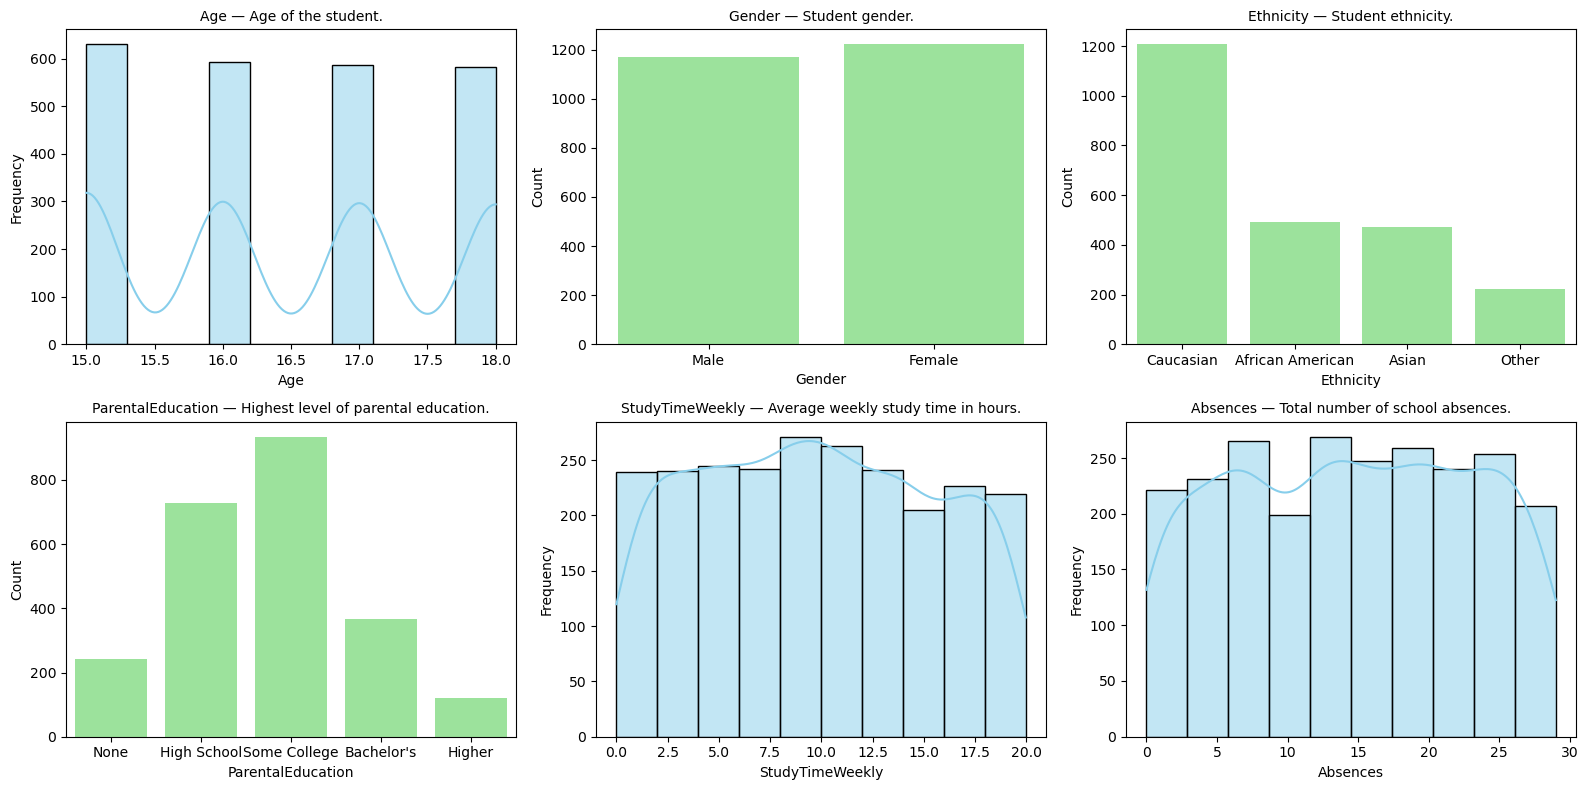

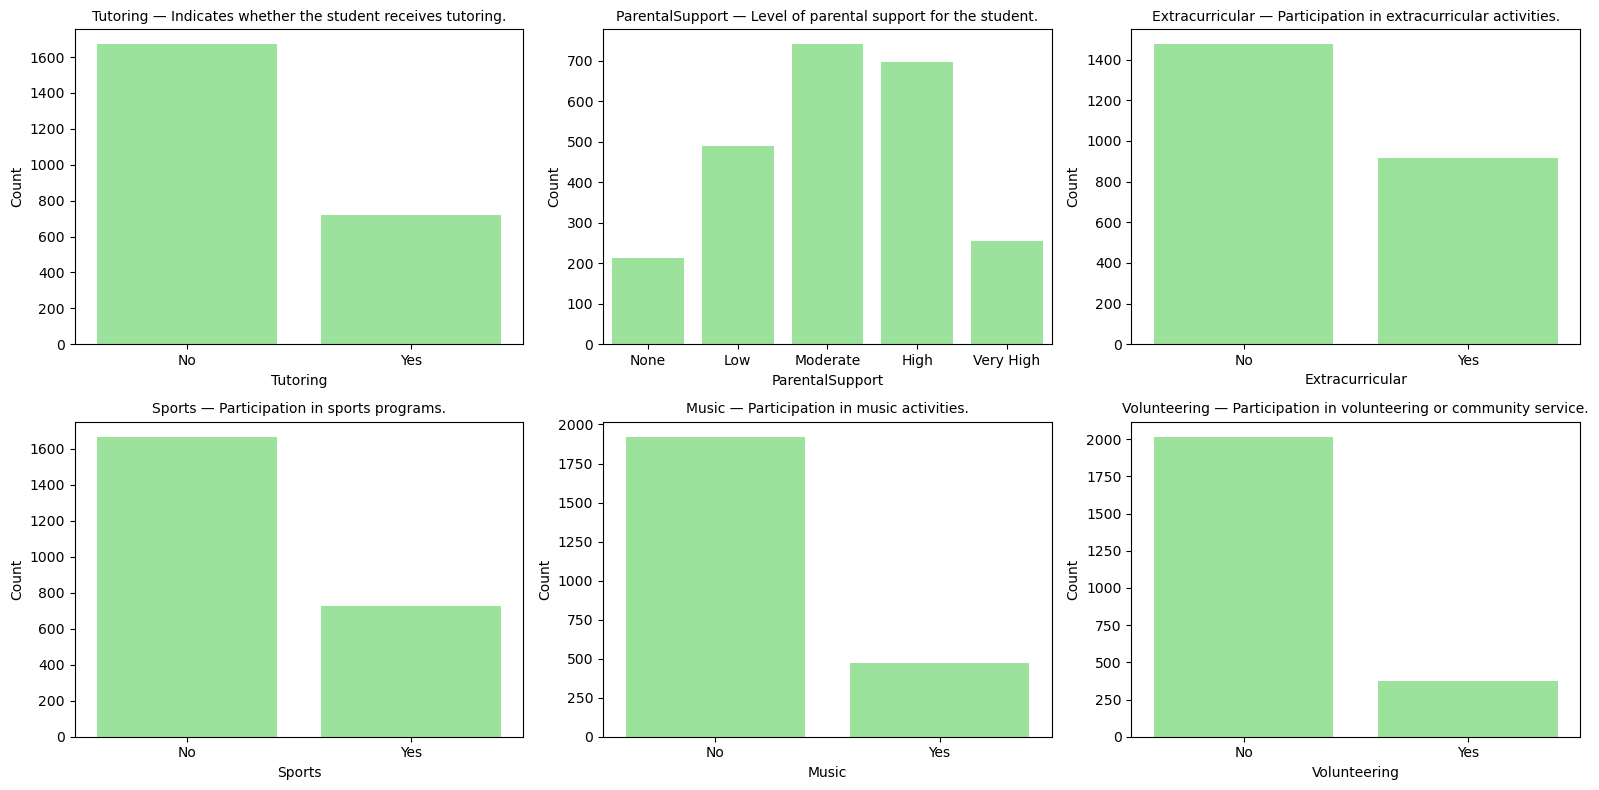

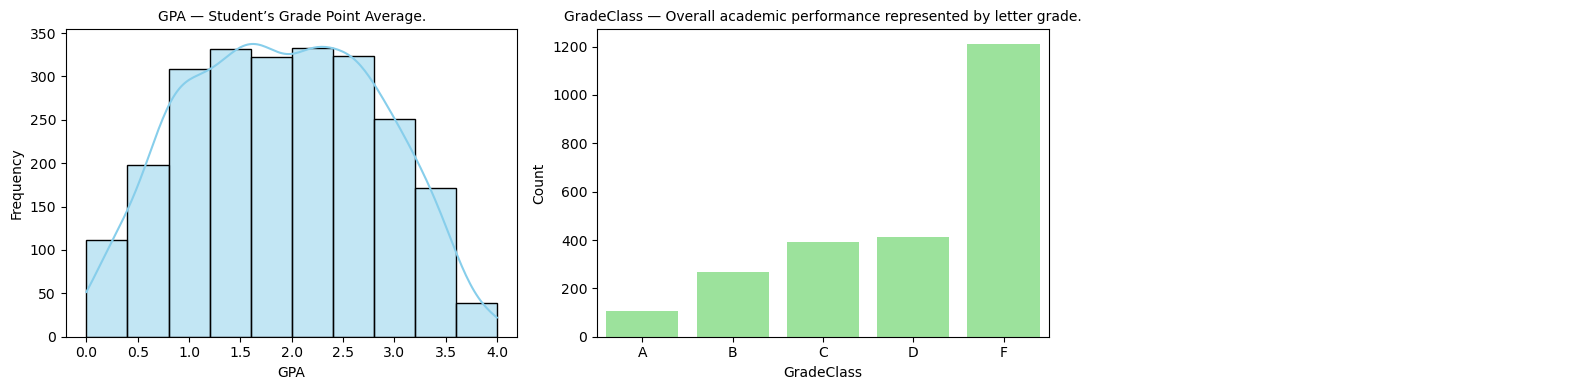

In [42]:
plot_multiple_hists(
    students,
    columns=students.columns[:6],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)
plot_multiple_hists(
    students,
    columns=students.columns[6:12],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)

plot_multiple_hists(
    students,
    columns=students.columns[12:],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 4)
)

### Descriptive Statistics for Each Feature

- **Age:** Uniform distribution between ages 15–18 with no dominant age group.  
- **Gender:** Roughly balanced split between male and female students.  
- **Ethnicity:** Imbalanced, with Caucasian students forming the majority; “Other” least represented.  
- **ParentalEducation:** Skewed toward “Some College” and “High School”; very few in “Higher” or “None.”  
- **StudyTimeWeekly:** Evenly spread across 0–20 hours with no dominant cluster.  
- **Absences:** Ranges from 0–30 days with a fairly uniform distribution.  
- **Tutoring:** Most students do not receive tutoring; small minority does.  
- **ParentalSupport:** Distributed across all five levels, with “Moderate” and “High” most common.  
- **Extracurricular:** Majority of students do not participate in extracurricular activities.  
- **Sports:** Strong imbalance, with many more non-participants than participants.  
- **Music:** Highly imbalanced, with most students not involved in music activities.  
- **Volunteering:** Majority of students do not volunteer.  
- **GPA:** Approximately symmetric distribution from 2.0–4.0, peaking mid–high GPA.  
- **GradeClass:** Strongly imbalanced, with “F” the most common grade class.
___

# **4. Exploratory Data Analysis**

#### Our EDA begins with the numerical features, using a correlation matrix to identify linear relationships and key predictors. We then explore the categorical variables through grouped visualizations that show how academic outcomes (GradeClass) differ across various demographic and behavioral categories.

<bound method NDFrame.describe of                       Age  StudyTimeWeekly  Absences       GPA  GradeClass
Age              1.000000        -0.006800 -0.011511  0.000275   -0.006250
StudyTimeWeekly -0.006800         1.000000  0.009326  0.179275   -0.134131
Absences        -0.011511         0.009326  1.000000 -0.919314    0.728633
GPA              0.000275         0.179275 -0.919314  1.000000   -0.782835
GradeClass      -0.006250        -0.134131  0.728633 -0.782835    1.000000>


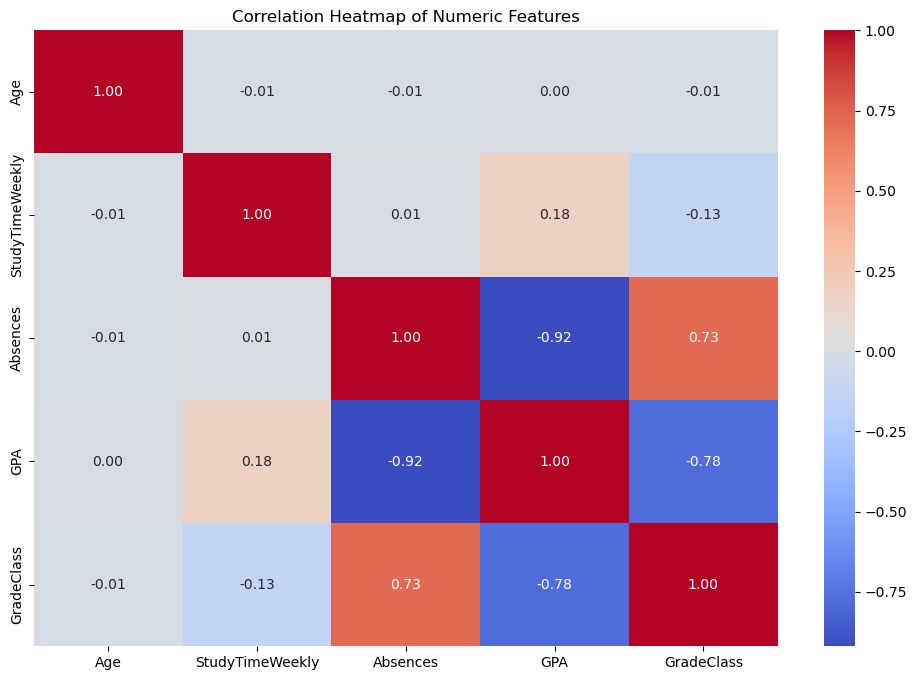

In [43]:
# Compute correlation matrix
corr = students_numeric.corr()

print(corr.describe)
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### **Interpretation of Heatmap Relationships**
#### **Note:** Correlation reflects association, not causation. While absences show a strong negative correlation with GPA, this does not by itself prove that absences *cause* lower GPA—only that they move together in this dataset.

#### The correlation matrix reveals two particularly strong relationships: a very strong negative correlation between Absences and GPA, indicating that students who miss more classes tend to perform substantially worse academically, and a strong positive correlation between Absences and GradeClass, since lower grades correspond to a higher GradeClass value. Likewise, GPA and GradeClass show a strong negative correlation because GradeClass is directly derived from GPA. StudyTimeWeekly shows only a weak positive correlation with GPA, suggesting that study hours alone do not strongly predict performance in this dataset. Age shows virtually no correlation with any academic outcome. Overall, Absences emerges as the most influential numeric predictor, while other numeric features exhibit limited relationship strength.

In [44]:
students_catogory.describe()

,Gender,Ethnicity,ParentalEducation,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
count,2392,2392,2392,2392,2392,2392,2392,2392,2392
unique,2,4,5,2,5,2,2,2,2
top,1,0,2,0,2,0,0,0,0
freq,1222,1207,934,1671,740,1475,1666,1921,2016


### **Now let us move to the relationships of the categorical features with GradeClass.**
#### - Its useful for EDA to visualize how academic outcomes are distributed across different demographic and behavioral categories.
#### - These stacked bar charts help reveal patterns such as whether certain groups tend to have higher or lower grade distributions, providing intuitive insight into how categorical factors relate to overall academic performance.

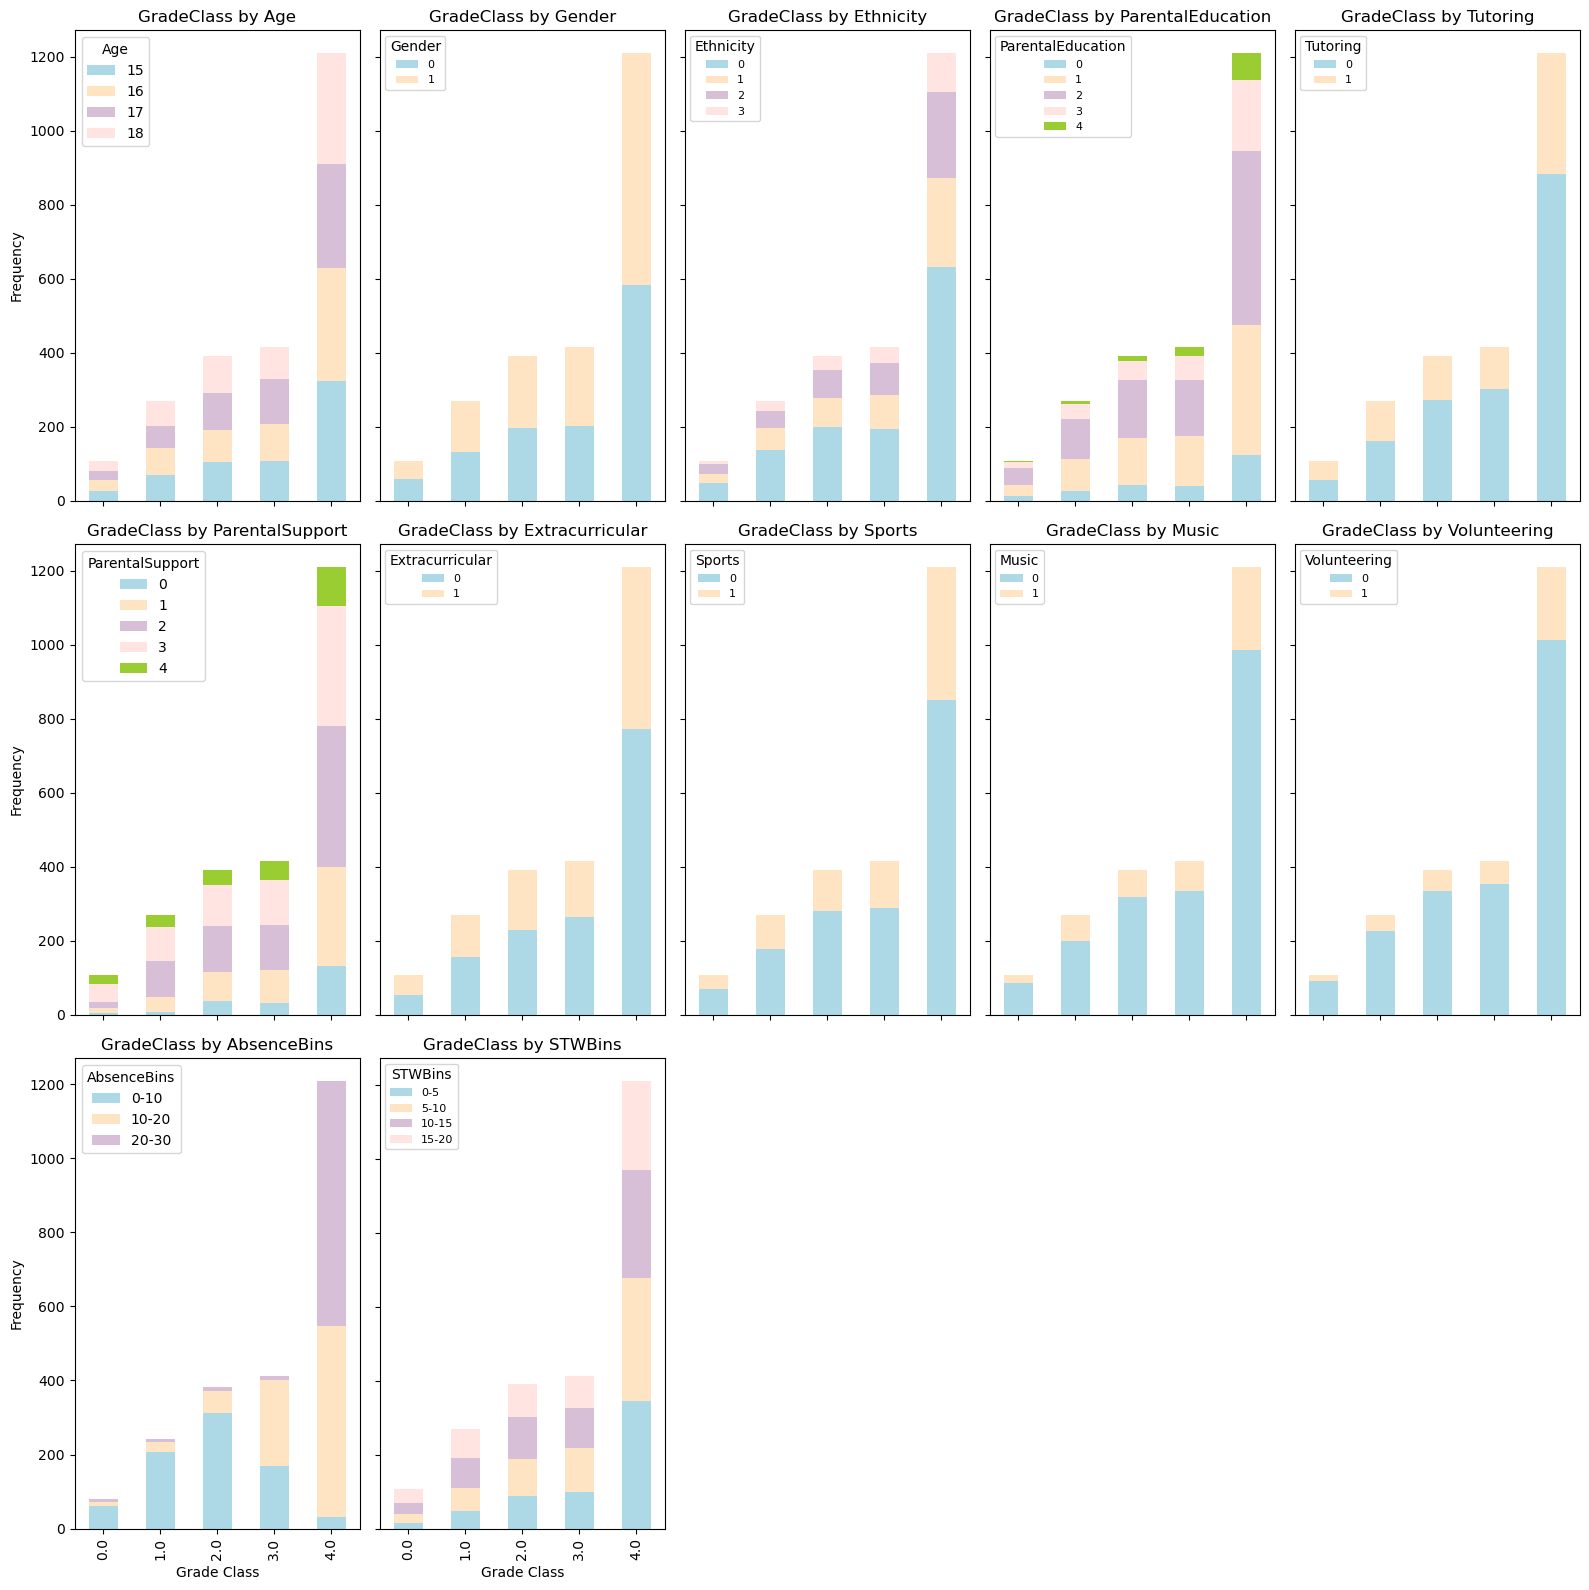

In [45]:
# --------------------------------------------
# Define color palette for stacked bar charts
# --------------------------------------------
colors = ['lightblue', 'bisque', 'thistle', 'mistyrose', 'yellowgreen']

# --------------------------------------------
# Prepare columns
# --------------------------------------------
base_categorical_cols = students.columns.drop(['Absences', 'StudyTimeWeekly', 'GPA', 'GradeClass'])

# Create bins for numeric variables
students["AbsenceBins"] = pd.cut(
    students["Absences"],
    bins=[0, 10, 20, 30],
    labels=["0-10", "10-20", "20-30"]
)

students["STWBins"] = pd.cut(
    students["StudyTimeWeekly"],
    bins=[0, 5, 10, 15, 20],
    labels=["0-5", "5-10", "10-15", "15-20"]
)

# Combine all variables to plot
plot_columns = list(base_categorical_cols) + ["AbsenceBins", "STWBins"]

ncols = 5 
nrows = 3 
# --------------------------------------------
# Create 3×3 subplot grid
# --------------------------------------------
fig, axes = plt.subplots(3, 5, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(plot_columns):

    ax = axes[i]

    # Build contingency table
    count = (
        students.groupby(["GradeClass", col], observed=True)
        .size()
        .unstack(fill_value=0)
    )

    count.plot(
        kind="bar",
        stacked=True,
        color=colors,
        ax=ax
    )

    ax.set_title(f"GradeClass by {col}", fontsize=12)

    # ---------------------------
    # Hide x-label except bottom row
    # ---------------------------
    row_index = i // ncols
    if row_index == nrows - 1:
        ax.set_xlabel("Grade Class")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    # ---------------------------
    # Hide y-label except left column
    # ---------------------------
    col_index = i % ncols
    if col_index == 0:
        ax.set_ylabel("Frequency")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    
        ax.legend(title=col, fontsize=8)

# Hide any unused subplot axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### **Interpretation of distributions between categorical features and GradeClass**
#### Across most demographic variables (age, gender, ethnicity, parental education), the distribution of GradeClass shows only minor differences, suggesting these factors do not strongly influence academic outcomes in this dataset. In contrast, several behavioral and support-related features display clear patterns: students with higher parental support, students involved in extracurricular activities or sports, and those receiving tutoring tend to have fewer failing grades and more mid-to-high grade outcomes. The most striking patterns appear in the binned numeric variables—AbsenceBins and STWBins—where higher absences are strongly associated with poorer GradeClass outcomes, and moderate-to-high study time shows a slight shift toward better grades. Overall, attendance and engagement-related factors appear far more predictive of academic success than demographic attributes.
___

## 4.1 Statistical Testing: Chi-Squared Test, T-Test, and ANOVA conventional alpha of 0.05

### Chi-Squared Test 
- We use the chi-squared test of independence when evaluating whether two **categorical variables** are related, such as GradeClass and Sports, ParentalSupport, Music, or binned variables like AbsenceBins and STWBins.
- Unlike ANOVA or t-tests, which compare **mean differences**, the chi-squared test assesses whether the **distribution** of one categorical variable differs significantly across the categories of another.
- The method works by comparing **observed frequencies** in a contingency table with **expected frequencies** that would occur if no relationship existed (the null hypothesis).
- A large chi-squared statistic indicates that the observed counts deviate substantially from what would be expected under independence, suggesting a meaningful association between the variables.
- Statistical significance is determined using the p-value at the conventional α = 0.05 threshold:
    - **p < 0.05** → Reject the null hypothesis; the variables show a significant association.  
    - **p ≥ 0.05** → Fail to reject the null hypothesis; no evidence of dependency between the variables.
- The chi-squared test is appropriate only for categorical variables (or numeric variables that have been binned) and is especially useful for analyzing **GradeClass**, since it is a naturally categorical outcome.


Chi-Square EDA: Age vs GradeClass

Chi-Square Test Results:
Chi² statistic: 10.7495
Degrees of freedom: 12
P-value: 0.550500
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

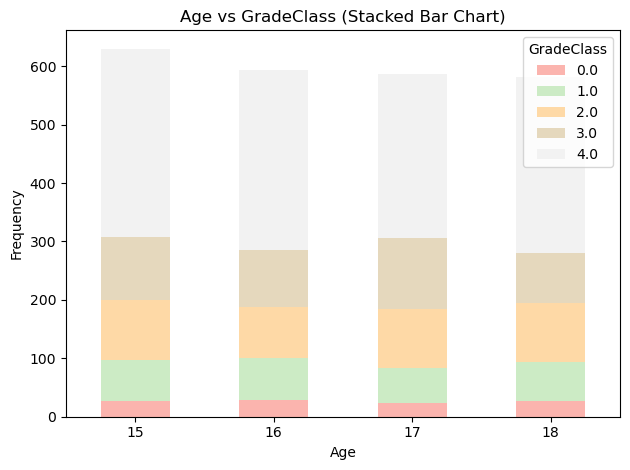



Chi-Square EDA: Gender vs GradeClass

Chi-Square Test Results:
Chi² statistic: 1.9154
Degrees of freedom: 4
P-value: 0.751320
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

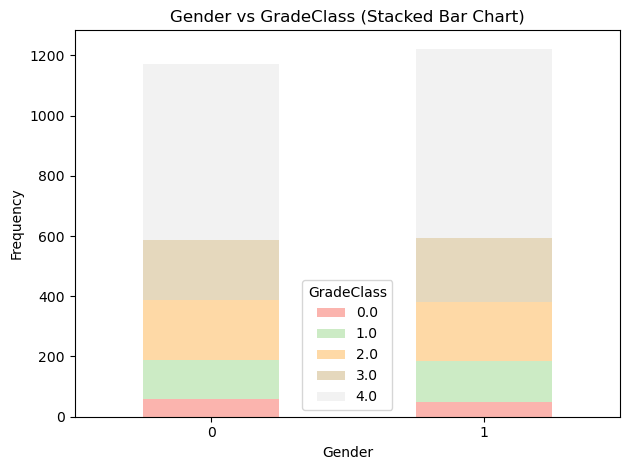



Chi-Square EDA: Ethnicity vs GradeClass

Chi-Square Test Results:
Chi² statistic: 7.9188
Degrees of freedom: 12
P-value: 0.791441
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

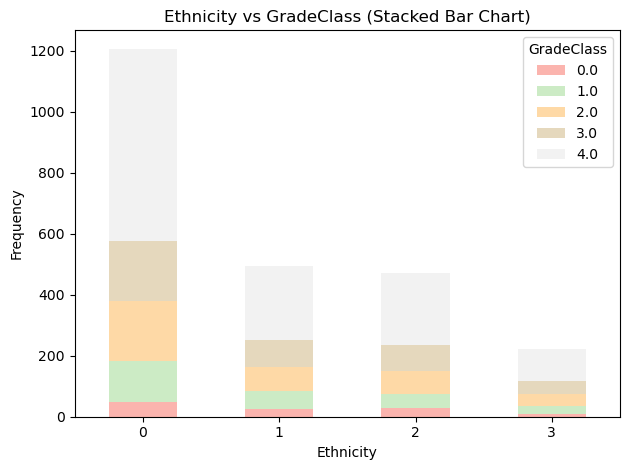



Chi-Square EDA: ParentalEducation vs GradeClass

Chi-Square Test Results:
Chi² statistic: 14.8820
Degrees of freedom: 16
P-value: 0.533298
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

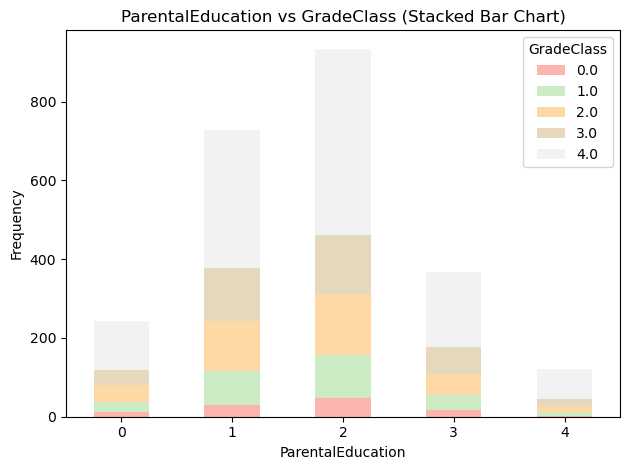



Chi-Square EDA: AbsenceBins vs GradeClass

Chi-Square Test Results:
Chi² statistic: 1518.1738
Degrees of freedom: 8
P-value: 0.000000
Result: Significant association (reject H₀).


<Figure size 700x500 with 0 Axes>

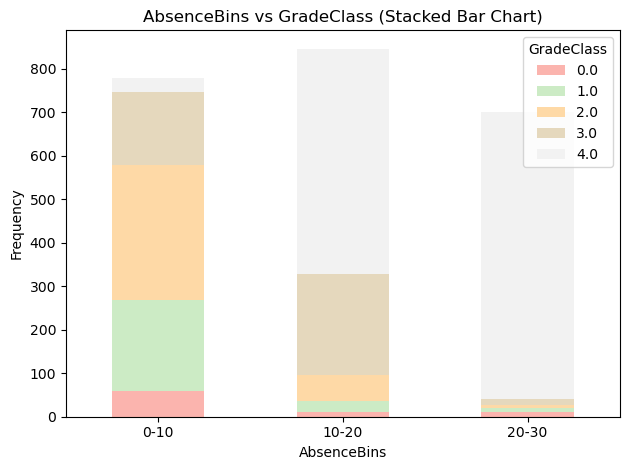



Chi-Square EDA: STWBins vs GradeClass

Chi-Square Test Results:
Chi² statistic: 43.4247
Degrees of freedom: 12
P-value: 0.000019
Result: Significant association (reject H₀).


<Figure size 700x500 with 0 Axes>

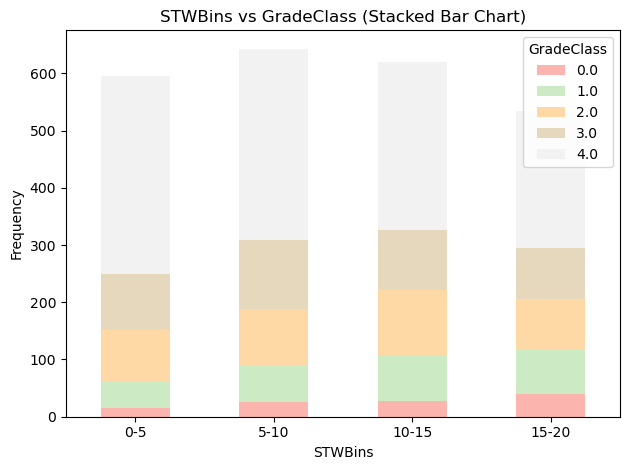



Chi-Square EDA: Tutoring vs GradeClass

Chi-Square Test Results:
Chi² statistic: 37.7516
Degrees of freedom: 4
P-value: 0.000000
Result: Significant association (reject H₀).


<Figure size 700x500 with 0 Axes>

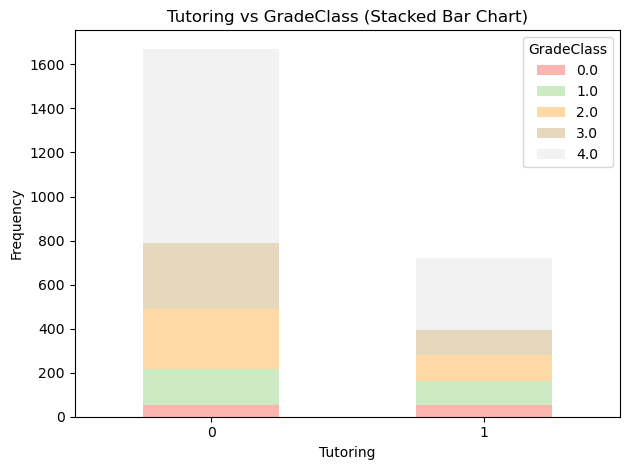



Chi-Square EDA: ParentalSupport vs GradeClass

Chi-Square Test Results:
Chi² statistic: 73.7827
Degrees of freedom: 16
P-value: 0.000000
Result: Significant association (reject H₀).


<Figure size 700x500 with 0 Axes>

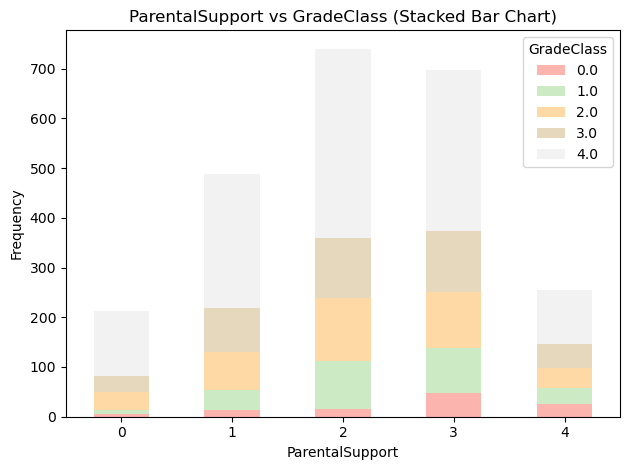



Chi-Square EDA: Extracurricular vs GradeClass

Chi-Square Test Results:
Chi² statistic: 14.2171
Degrees of freedom: 4
P-value: 0.006634
Result: Significant association (reject H₀).


<Figure size 700x500 with 0 Axes>

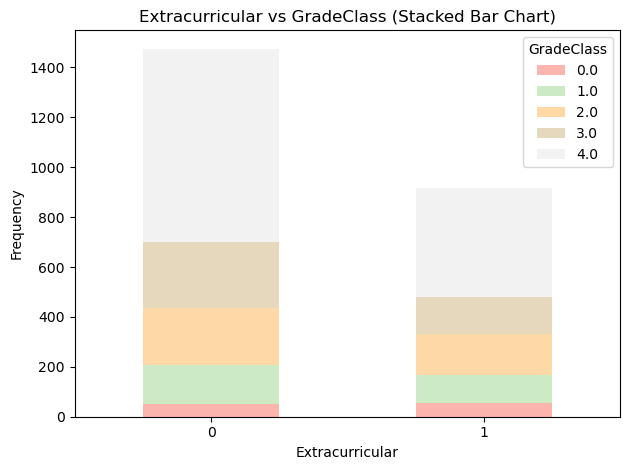



Chi-Square EDA: Sports vs GradeClass

Chi-Square Test Results:
Chi² statistic: 4.3692
Degrees of freedom: 4
P-value: 0.358336
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

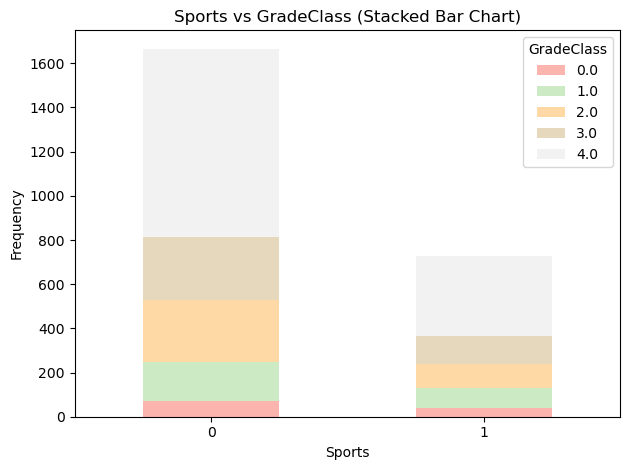



Chi-Square EDA: Music vs GradeClass

Chi-Square Test Results:
Chi² statistic: 7.8915
Degrees of freedom: 4
P-value: 0.095636
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

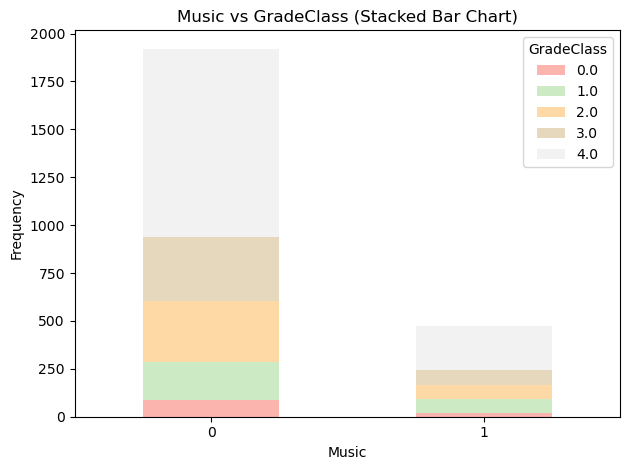



Chi-Square EDA: Volunteering vs GradeClass

Chi-Square Test Results:
Chi² statistic: 1.4829
Degrees of freedom: 4
P-value: 0.829666
Result: No significant association (fail to reject H₀).


<Figure size 700x500 with 0 Axes>

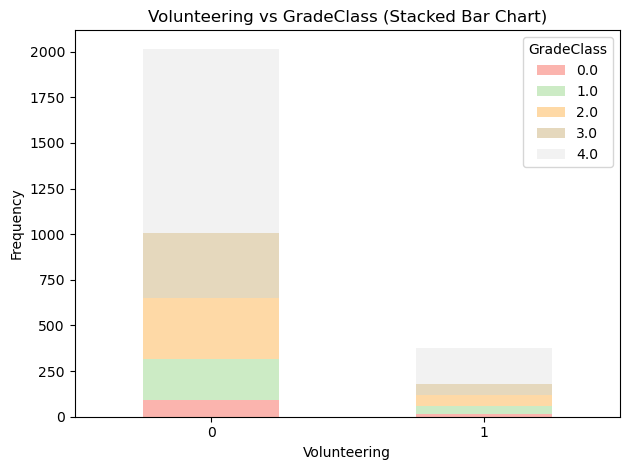

In [46]:
# Categorical columns to test 
chi_cols = [
    "Age", "Gender", "Ethnicity", "ParentalEducation",
    "AbsenceBins", "STWBins", "Tutoring", "ParentalSupport",
    "Extracurricular", "Sports", "Music", "Volunteering"
]

for col in chi_cols:
    run_chi_square_test(students, col)

### T-Test (Binary Categorical Variables)
- We use t-tests when comparing mean GPA between two groups (e.g., Gender, Tutoring, Sports).
- A t-test evaluates whether the difference in mean GPA is large enough relative to natural variability within each group to conclude that the groups truly differ rather than the difference arising by chance.
- The t-statistic is not simply the difference in group means; it also adjusts for within-group variability, sample size, and the standard error of the difference.
- This allows us to determine whether the GPA difference between two categories is statistically meaningful.


EDA Analysis: GPA by Gender

Running Independent Samples T-Test...

Group 1 mean: 1.894
Group 0 mean: 1.919
T-statistic: -0.6532
P-value: 0.513668
Result: No significant difference between groups (p ≥ 0.05).


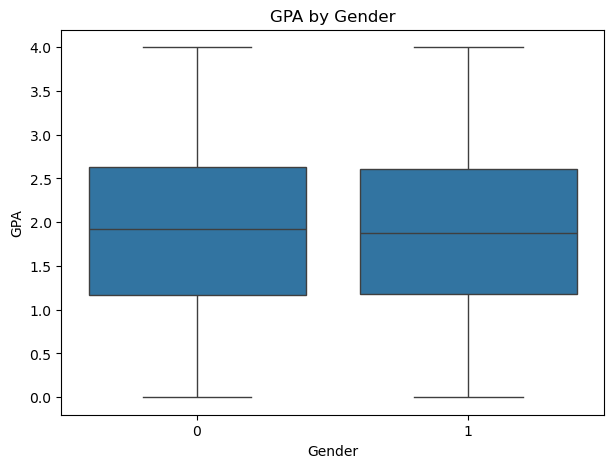



EDA Analysis: GPA by Tutoring

Running Independent Samples T-Test...

Group 1 mean: 2.108
Group 0 mean: 1.819
T-statistic: 7.1725
P-value: 0.000000
Result: Significant difference between groups (p < 0.05).


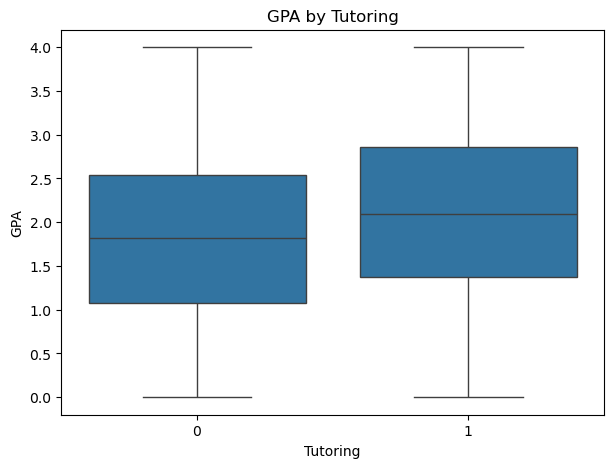



EDA Analysis: GPA by Extracurricular

Running Independent Samples T-Test...

Group 0 mean: 1.838
Group 1 mean: 2.015
T-statistic: -4.6086
P-value: 0.000004
Result: Significant difference between groups (p < 0.05).


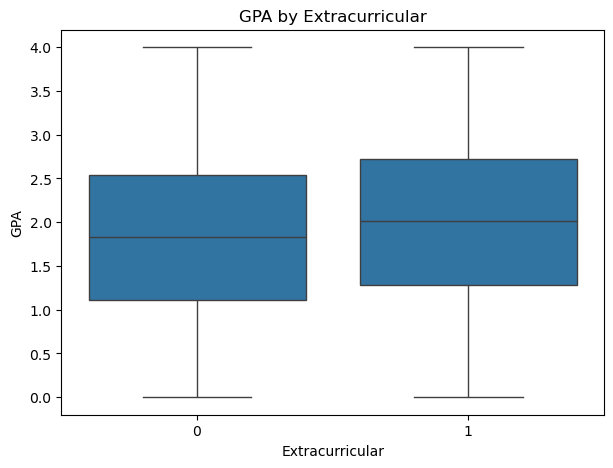



EDA Analysis: GPA by Sports

Running Independent Samples T-Test...

Group 0 mean: 1.871
Group 1 mean: 1.986
T-statistic: -2.8514
P-value: 0.004416
Result: Significant difference between groups (p < 0.05).


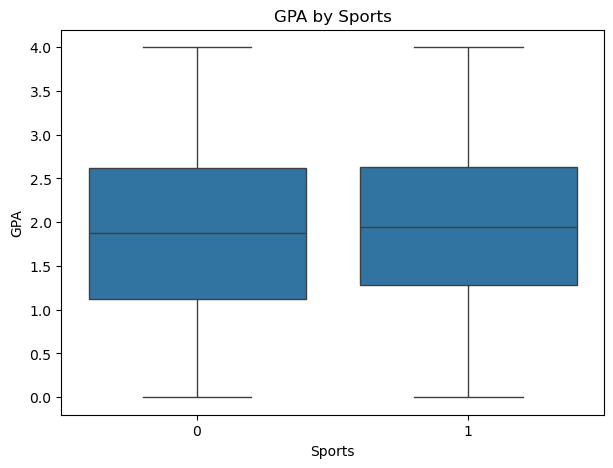



EDA Analysis: GPA by Music

Running Independent Samples T-Test...

Group 1 mean: 2.042
Group 0 mean: 1.873
T-statistic: 3.5971
P-value: 0.000344
Result: Significant difference between groups (p < 0.05).


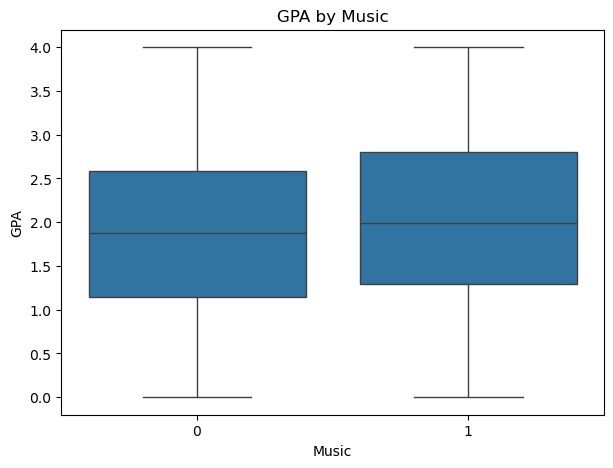



EDA Analysis: GPA by Volunteering

Running Independent Samples T-Test...

Group 0 mean: 1.905
Group 1 mean: 1.913
T-statistic: -0.1611
P-value: 0.872068
Result: No significant difference between groups (p ≥ 0.05).


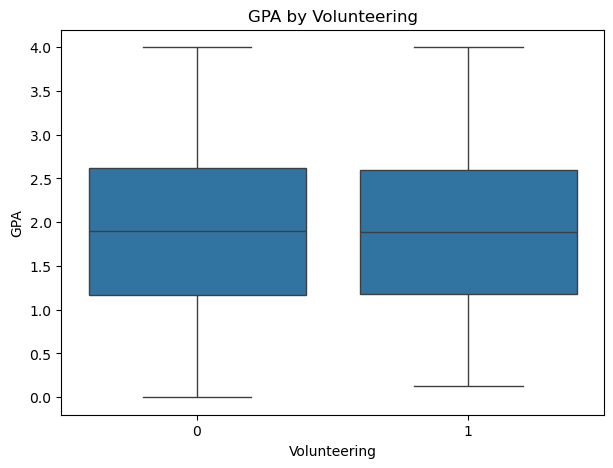

In [47]:
# Binary (t-test)
run_eda_test(students, "Gender", "GPA")
run_eda_test(students, "Tutoring", "GPA")
run_eda_test(students, "Extracurricular", "GPA")
run_eda_test(students, "Sports", "GPA")
run_eda_test(students, "Music", "GPA")
run_eda_test(students, "Volunteering", "GPA")

### ANOVA (Categorical Variables with 3 or More Groups)
- We use one-way ANOVA when comparing mean GPA across three or more categories (e.g., Ethnicity, ParentalEducation, ParentalSupport).
- ANOVA evaluates whether at least one group mean differs from the others by comparing variation between groups to variation within groups.
- If the between-group variation is substantially larger than the within-group variation, the F-statistic becomes large, indicating that not all group means are equal.
- ANOVA is necessary because it avoids inflated Type I error from running multiple t-tests, properly handles 3+ group comparisons in a single unified test, and determines whether meaningful group differences exist before examining specific pairs.
    - A Type I error occurs when we incorrectly conclude that a significant difference exists between groups when it actually does not — essentially a false positive.

EDA Analysis: GPA by Ethnicity

Running One-Way ANOVA...

Group Means:
  0: 1.876
  2: 1.922
  1: 1.946
  3: 1.948

F-statistic: 0.9581
P-value: 0.411585
Result: No significant differences (p ≥ 0.05).


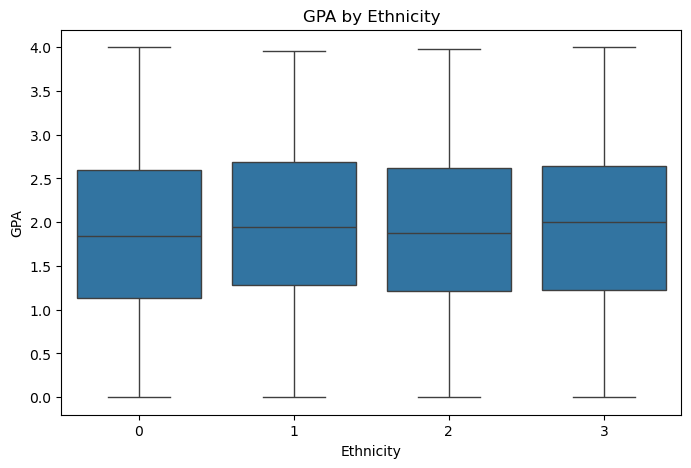



EDA Analysis: GPA by ParentalEducation

Running One-Way ANOVA...

Group Means:
  2: 1.930
  1: 1.944
  3: 1.809
  4: 1.816
  0: 1.893

F-statistic: 1.8081
P-value: 0.124484
Result: No significant differences (p ≥ 0.05).


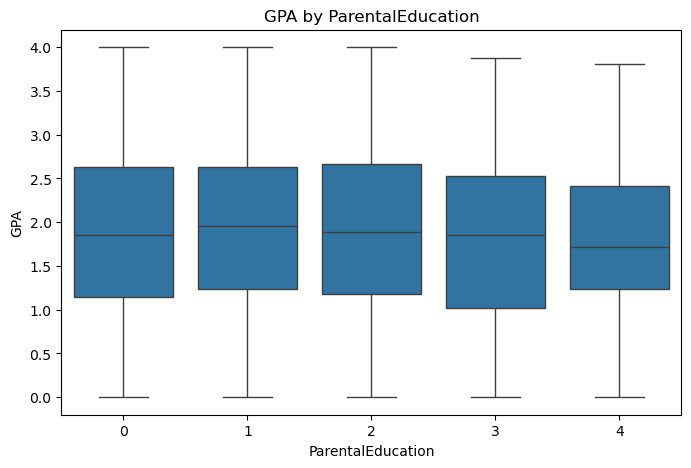



EDA Analysis: GPA by ParentalSupport

Running One-Way ANOVA...

Group Means:
  2: 1.884
  1: 1.756
  3: 2.042
  4: 2.192
  0: 1.540

F-statistic: 22.7235
P-value: 0.000000
Result: Significant differences among groups (p < 0.05).


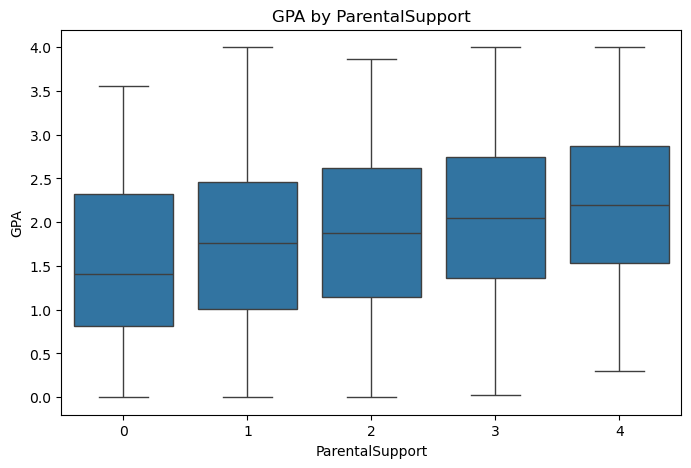



EDA Analysis: GPA by STWBins

Running One-Way ANOVA...

Group Means:
  15-20: 2.106
  0-5: 1.692
  10-15: 1.999
  5-10: 1.849

F-statistic: 22.9676
P-value: 0.000000
Result: Significant differences among groups (p < 0.05).


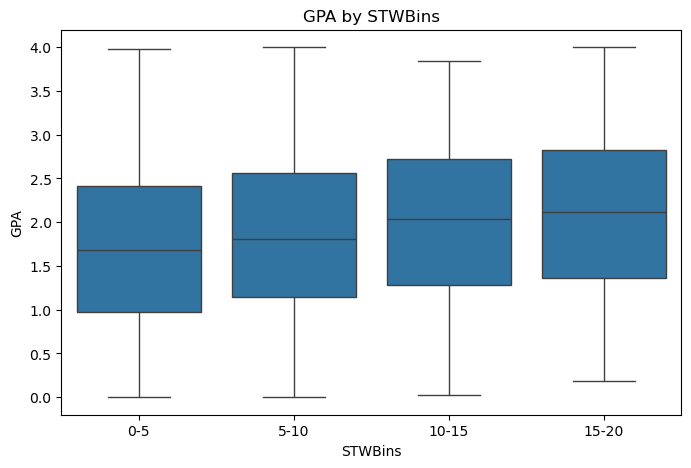

In [48]:
# Multi-category (ANOVA)
run_eda_test(students, "Ethnicity", "GPA")
run_eda_test(students, "ParentalEducation", "GPA")
run_eda_test(students, "ParentalSupport", "GPA")
run_eda_test(students, "STWBins", "GPA")

## Summary of findings and test results

We conducted two complementary statistical approaches:
- **T-tests and ANOVA** to evaluate how categorical features affect the numeric outcome *GPA*
- **Chi-square tests** to assess relationships with the categorical outcome *GradeClass*
___

### Visual and Statistical Consistency
The stacked bar charts show distribution patterns that align with the chi-square hypothesis tests. Features that exhibit clear shifts in GradeClass distribution—such as AbsenceBins and ParentalSupport—also produce statistically significant chi-square results, strengthening the evidence for their association with academic performance.
___

### Features Significant in Both Analyses (Strong Predictors)
These variables significantly affect both GPA and GradeClass:
- **Absences / AbsenceBins**
- **StudyTimeWeekly (STWBins)**
- **ParentalSupport**
- **Tutoring**
- **Extracurricular participation**

These features consistently appear across multiple statistical tests, strengthening confidence in their importance.

---

### Features Significant Only for GPA (Moderate Predictors)
Some activities influence GPA slightly but do not shift students enough to change their GradeClass category:
- **Sports**
- **Music**
- **Volunteering**

These predictors produce small but detectable GPA differences (t-tests/ANOVA) but do not create large enough distribution shifts to register as significant in the chi-square tests for GradeClass.

---

### Features Not Statistically Significant
The following features did not show significant relationships with either outcome:
- **Age**
- **Gender**
- **Ethnicity**
- **ParentalEducation** (for GradeClass; effects on GPA were mild)

---

### **Overall EDA Interpretation**
Student performance is most strongly influenced by:
- **attendance (Absences)**,
- **study engagement (STWBins, Tutoring, Extracurriculars)**,
- and **family environment (ParentalSupport)**.


#### Other activities such as **sports** and **music** contribute to slight GPA differences but do not meaningfully shift GradeClass distributions. This distinction highlights how continuous (GPA) and categorical (GradeClass) targets respond differently to the same predictors, providing a richer understanding of student performance patterns.
___

# **5. Modeling: Predicting Student Performance**

#### In the previous sections, we explored the dataset through descriptive statistics, statical testing, and visual analysis to understand initial patterns and relationships. However, these insights only provide a qualitative understanding of the factors that may influence student performance. In this section, we move from exploratory data analysis (EDA) to building predictive models.

#### We use the `students` DataFrame prepared above and the existing `categorical_cols` to:

- Predict GPA as a continuous outcome (regression)
- Predict whether a student is "at risk" based on GPA (classification)
- Compare multiple models within each task
___

## 5.1 Model Theory Overview

This section provides a clear, theoretical foundation for all machine learning models we use in our project.  
It explains the mathematical intuition, core algorithms, and why each method is appropriate for predicting GPA, classifying at-risk students, and discovering natural groups through clustering.

---

### Linear Regression (GPA Prediction)

Linear Regression models the relationship between a set of predictors \(X\) and a continuous outcome \(y\).  
It assumes that GPA can be expressed as a weighted sum of features plus noise:

$$
y = X\beta + \epsilon
$$

The goal is to find coefficients \(\beta\) that minimize the Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Linear Regression is interpretable and provides a strong baseline.  
It helps quantify how each variable contributes to GPA under a linear assumption.

---

### Logistic Regression (Binary At-Risk Classification)

Logistic Regression models the probability that a student is “at risk” (1) vs. “not at risk” (0).  
Instead of modeling the outcome directly, it models the log-odds:

$$
\log\left(\frac{p}{1 - p}\right) = X\beta
$$

Predicted probabilities come from the sigmoid function:

$$
p = \frac{1}{1 + e^{-X\beta}}
$$

Training minimizes Binary Cross-Entropy loss:

$$
\mathcal{L} = -\frac{1}{n}\sum_{i=1}^n \left[y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i)\right]
$$

Logistic Regression is highly interpretable and establishes a strong classification baseline.

---

### Decision Trees

Decision Trees recursively split the feature space into regions, learning a set of human-readable rules.  
At each split, the algorithm chooses the feature and threshold that most reduce impurity.

**Gini Impurity:**
$$
G = \sum_{k=1}^{K} p_k (1 - p_k)
$$

**Entropy:**
$$
H = -\sum_{k=1}^{K} p_k \log(p_k)
$$

Decision trees naturally model nonlinear relationships and interactions between features.

---

### Random Forests (Ensemble of Decision Trees)

Random Forests are ensembles of many decision trees trained on:
- Bootstrap samples of the data  
- Random subsets of features at each split  

This decorrelation creates a more stable, lower-variance model.

Predictions are aggregated via:
- Mean (regression)  
- Majority vote (classification)

Random Forests handle mixed data types, nonlinearities, and high-dimensional spaces extremely well.

---

### XGBoost (Extreme Gradient Boosting)

XGBoost builds trees sequentially, where each tree corrects the errors of previous trees.  
This is called gradient boosting, and XGBoost extends it with regularization and second-order optimization.

Additive model:
$$
\hat{y}^{(t)} = \hat{y}^{(t-1)} + f_t(x)
$$

Objective function:
$$
\mathcal{L} = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{t} \Omega(f_t)
$$

Regularization term:
$$
\Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_j w_j^2
$$

XGBoost is powerful due to:
- Use of first and second derivatives  
- Built-in L1/L2 regularization  
- Ability to model complex nonlinear relationships  
- Exceptional performance on tabular data  

This model often provides the strongest results in both regression and classification tasks.

---

### K-Means Clustering

K-Means is an unsupervised algorithm that separates observations into \(k\) clusters by minimizing within-cluster variance:

$$
\sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Where \(\mu_i\) is the centroid of cluster \(i\).  
The algorithm iterates between:

1. Assigning each point to the nearest centroid  
2. Updating centroids as the mean of the assigned points  

This method identifies natural student subgroups (e.g., high performers, inconsistent performers), adding insight beyond supervised modeling.

---

### Principal Component Analysis (PCA)

PCA reduces dimensionality by finding directions (principal components) that capture the most variance in the data.

Optimization problem:
$$
\max_{\mathbf{w}} \ \mathbf{w}^T \Sigma \mathbf{w}
$$

Eigenvalue equation:
$$
\Sigma \mathbf{w} = \lambda \mathbf{w}
$$

PCA allows:
- Visualization of clusters  
- Noise reduction  
- Understanding feature relationships  

It is especially helpful for plotting K-Means results in 2D.

---

### Summary of Model Purpose in This Project

- **Linear Regression:** Baseline GPA prediction  
- **Logistic Regression:** Baseline binary at-risk classification  
- **Decision Trees:** Rule-based, interpretable models  
- **Random Forests:** Strong nonlinear ensemble models  
- **XGBoost:** High-performance boosting model with regularization  
- **K-Means:** Unsupervised discovery of student subgroups  
- **PCA:** Dimensionality reduction and visualization  

Together, these models provide a rich combination of predictive power, interpretability, and exploratory insight.
___

## 5.2 Data Preprocessing and Train/Test Split

#### We define an “at-risk” student as one whose GPA falls below 2.5. This threshold roughly corresponds to a C average and is commonly used in academic performance research to identify students who may require additional support. Students below this cutoff are labeled with `at_risk = 1`.

#### In this section, we prepare the dataset for all subsequent modeling steps by defining the regression and classification targets, selecting numerical and categorical features, and constructing a unified preprocessing pipeline. Numerical variables are standardized using `StandardScaler`, while categorical variables are encoded with `OneHotEncoder` to ensure that every model receives clean, machine-readable inputs. After establishing the preprocessing pipeline, we generate train–test splits for both the regression and classification tasks. These steps create a consistent, reproducible foundation for the supervised and unsupervised models developed in later sections of section 5.

In [49]:
# Regression target
target_reg = "GPA"

# Classification target: 1 = at risk (low GPA), 0 = not at risk
risk_threshold = 2.5  # adjust if needed
students["at_risk"] = (students["GPA"] < risk_threshold).astype(int)
target_clf = "at_risk"

In [50]:
# Define numeric and categorical features using existing variables from our EDA

# Numeric features = all numeric columns except the targets
numeric_features = students.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove targets from numeric feature list
for col in [target_reg, target_clf]:
    if col in numeric_features:
        numeric_features.remove(col)

# Explicitly remove GradeClass if it shows up as numeric (safety against leakage)
if "GradeClass" in numeric_features:
    numeric_features.remove("GradeClass")

# If you have any ID-like columns, drop them here manually, e.g.:
# if "StudentID" in numeric_features:
#     numeric_features.remove("StudentID")

numeric_features, categorical_cols

(['Age', 'StudyTimeWeekly', 'Absences'],
 ['Gender',
  'Ethnicity',
  'ParentalEducation',
  'ParentalSupport',
  'Tutoring',
  'Extracurricular',
  'Sports',
  'Music',
  'Volunteering'])

In [51]:
# Preprocessing pipeline and train/test split

# ColumnTransformer to scale numerics and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Feature matrix (same for both tasks)
X = students[numeric_features + categorical_cols]

# Targets
y_reg = students[target_reg]
y_clf = students[target_clf]

# Train/test splits
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

## 5.3 Regression Model Training and Evaluation

#### In this section, we train several regression models using the preprocessing pipeline defined in Section 5.2. Each model is fitted on the training data and evaluated on the test set using a standardized regression evaluation function. The performance metrics that will be interpreted and compared in Section 6.

In [52]:
# Linear Regression
linreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_model.fit(X_train_reg, y_train_reg)
y_pred_linreg = linreg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_linreg, "Linear Regression")

--- Linear Regression ---
MAE:  0.1551
MSE:  0.0385
RMSE: 0.1963
R²:   0.9534



In [53]:
# Random Forest Regressor
rf_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

rf_reg_model.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_rf_reg, "Random Forest Regressor")

--- Random Forest Regressor ---
MAE:  0.1960
MSE:  0.0639
RMSE: 0.2527
R²:   0.9228



In [54]:
# XGBoost Regressor (because it's popular and I'm curious to compare)
xgb_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_reg_model.fit(X_train_reg, y_train_reg)
y_pred_xgb_reg = xgb_reg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_xgb_reg, "XGBoost Regressor")

--- XGBoost Regressor ---
MAE:  0.1836
MSE:  0.0542
RMSE: 0.2328
R²:   0.9345



## 5.4 Classification Model Training and Evaluation

#### In this section, we train multiple classification models to predict whether a student is “at risk” according to the 2.5 GPA threshold defined in Section 5.2. Each classifier is wrapped in the same preprocessing pipeline used earlier, ensuring consistent scaling of numerical features and one-hot encoding of categorical variables. We fit each model on the training data and generate performance metrics on the test set using a standardized evaluation function. The performance metrics that will be interpreted and compared in Section 6.

In [55]:
# logistic regression
log_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE()),         # <---------- [chatgpt disclosure]: class imbalance handler
    ("model", LogisticRegression(max_iter=500))
])

log_clf_model.fit(X_train_clf, y_train_clf)
y_pred_log = log_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_log, "Logistic Regression")

--- Logistic Regression ---
Accuracy:  0.9436
Precision: 0.9812
Recall:    0.9371
F1 Score:  0.9587

Confusion Matrix:
[[139   6]
 [ 21 313]]



In [56]:
# Random Forest Classifier
rf_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE()),         # <---------- [chatgpt disclosure]: class imbalance handler
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_clf_model.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_rf, "Random Forest Classifier")

--- Random Forest Classifier ---
Accuracy:  0.9269
Precision: 0.9544
Recall:    0.9401
F1 Score:  0.9472

Confusion Matrix:
[[130  15]
 [ 20 314]]



In [57]:
# XGBoost Classifier
xgb_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE()),         # <---------- [chatgpt disclosure]: class imbalance handler
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

xgb_clf_model.fit(X_train_clf, y_train_clf)
y_pred_xgb = xgb_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_xgb, "XGBoost Classifier")

--- XGBoost Classifier ---
Accuracy:  0.9415
Precision: 0.9581
Recall:    0.9581
F1 Score:  0.9581

Confusion Matrix:
[[131  14]
 [ 14 320]]



## 5.5 Unsupervised Clustering Model Training

#### In this section, we train a K-Means clustering model using the fully preprocessed dataset. The focus here is on running the clustering algorithm and generating the resulting cluster assignments and basic summary outputs. Detailed interpretation of the cluster structure, visualizations, and insights will be presented in Section 6.

In [58]:
X_cluster = students[numeric_features + categorical_cols]

# Transform using the existing preprocessor
X_cluster_processed = preprocessor.fit_transform(X_cluster)

X_cluster_processed.shape

(2392, 29)

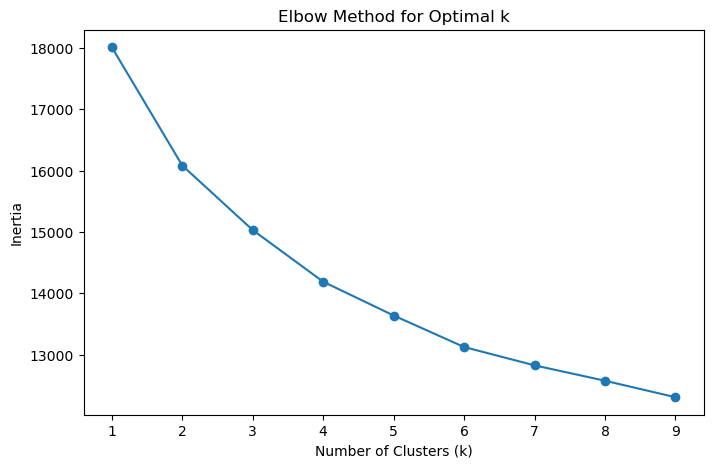

In [59]:
inertia = []
k_values = range(1, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster_processed)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


#### The elbow plot shows how the K-Means inertia (sum of squared distances to cluster centers) decreases as k increases. We look for the point where additional clusters provide only marginal improvement—this indicates diminishing returns. In our case, inertia decreases sharply between k = 1 and k = 4, but the slope flattens noticeably after k = 4. This “bend” or “elbow” suggests that k = 4 provides a good balance between compact clusters and model simplicity, making it the most appropriate choice for our final K-Means model.

In [60]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster_processed)

students["Cluster"] = cluster_labels
students["Cluster"].value_counts()

Cluster
0    618
1    605
3    596
2    573
Name: count, dtype: int64

# **6. Model Performance Comparison (Metrics and Interpretation)**

#### In this section, we consolidate and interpret the performance results of all regression and classification models trained in section 5. Side-by-side comparison tables and visualizations are used to summarize key evaluation metrics—MAE, RMSE, and R² for regression models, and accuracy, precision, recall, and F1 score for classification models. In addition to reporting these metrics, we provide accompanying interpretation to explain how each model performed, highlight meaningful differences between algorithms, and identify the strongest overall performers based on empirical results.
___

## 6.1 Regression results

In [61]:
# Extract feature names after one-hot encoding
ohe = rf_reg_model.named_steps["preprocess"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_features, encoded_cat_cols])

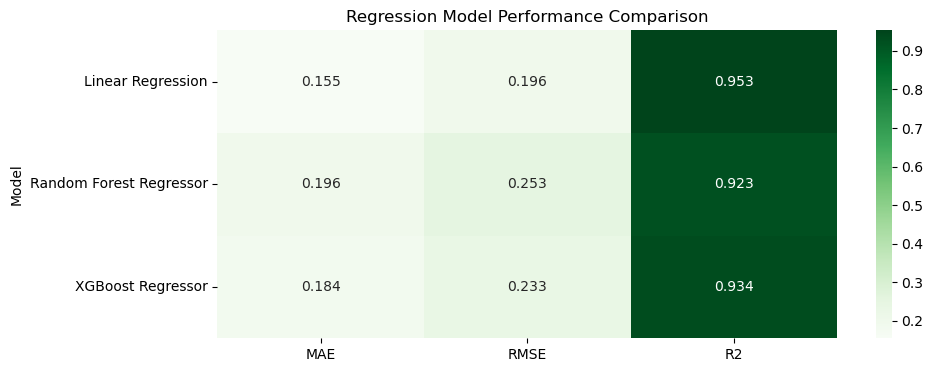

In [62]:
regression_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Regressor"],
    "MAE": [
        mean_absolute_error(y_test_reg, y_pred_linreg),
        mean_absolute_error(y_test_reg, y_pred_rf_reg),
        mean_absolute_error(y_test_reg, y_pred_xgb_reg)
    ],
    "RMSE": [
        math.sqrt(mean_squared_error(y_test_reg, y_pred_linreg)),
        math.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg)),
        math.sqrt(mean_squared_error(y_test_reg, y_pred_xgb_reg))
    ],
    "R2": [
        r2_score(y_test_reg, y_pred_linreg),
        r2_score(y_test_reg, y_pred_rf_reg),
        r2_score(y_test_reg, y_pred_xgb_reg)
    ]
})

plt.figure(figsize=(10,4))
sns.heatmap(regression_results.set_index("Model"), annot=True, fmt=".3f", cmap="Greens")
plt.title("Regression Model Performance Comparison")
plt.show()

                Feature  Importance
2              Absences    0.844156
14    ParentalSupport_0    0.303947
18    ParentalSupport_4    0.298488
1       StudyTimeWeekly    0.165511
17    ParentalSupport_3    0.145978
15    ParentalSupport_1    0.141685
19           Tutoring_0    0.129074
20           Tutoring_1    0.129074
22    Extracurricular_1    0.094832
21    Extracurricular_0    0.094832
23             Sports_0    0.092246
24             Sports_1    0.092246
25              Music_0    0.075763
26              Music_1    0.075763
12  ParentalEducation_3    0.013649


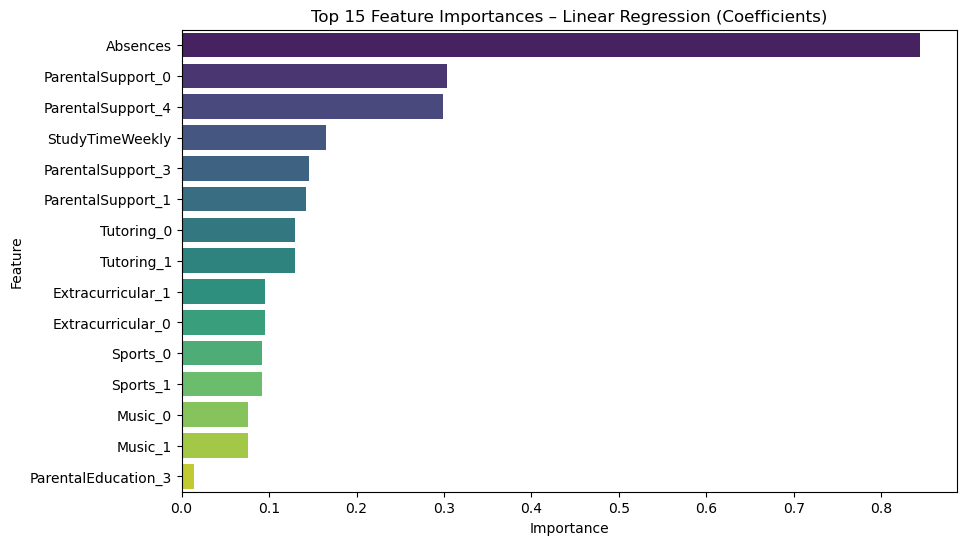

In [63]:
# Linear Regression
lin_reg_coefs = linreg_model.named_steps["model"].coef_
lin_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": np.abs(lin_reg_coefs)
}).sort_values("Importance", ascending=False)
print(lin_reg_df.head(15))
plot_feature_importances(
    lin_reg_df,
    "Top 15 Feature Importances – Linear Regression (Coefficients)",
    palette="viridis"
)

                Feature  Importance
2              Absences    0.853273
1       StudyTimeWeekly    0.057347
19           Tutoring_0    0.008131
14    ParentalSupport_0    0.007964
18    ParentalSupport_4    0.007662
20           Tutoring_1    0.007653
15    ParentalSupport_1    0.005783
0                   Age    0.005711
17    ParentalSupport_3    0.005023
21    Extracurricular_0    0.004086
23             Sports_0    0.003965
22    Extracurricular_1    0.003899
24             Sports_1    0.003669
25              Music_0    0.002230
11  ParentalEducation_2    0.002129


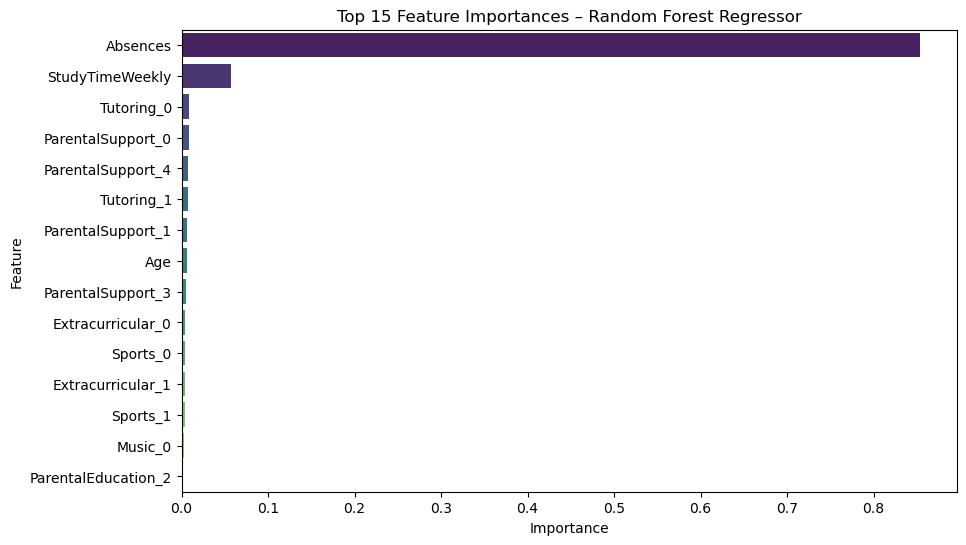

In [64]:
# Random Forest Regression

rf_reg_importances = rf_reg_model.named_steps["model"].feature_importances_

# Create a dataframe
rf_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf_reg_importances
}).sort_values("Importance", ascending=False)

print(rf_reg_df.head(15))


# Random Forest Regressor
plot_feature_importances(
    rf_reg_df,
    "Top 15 Feature Importances – Random Forest Regressor",
    palette="viridis"
)

                Feature  Importance
2              Absences    0.428594
14    ParentalSupport_0    0.063091
19           Tutoring_0    0.049535
18    ParentalSupport_4    0.049092
20           Tutoring_1    0.035641
24             Sports_1    0.034610
22    Extracurricular_1    0.033510
17    ParentalSupport_3    0.033011
25              Music_0    0.029156
15    ParentalSupport_1    0.026594
21    Extracurricular_0    0.026069
23             Sports_0    0.025025
1       StudyTimeWeekly    0.021906
13  ParentalEducation_4    0.021193
26              Music_1    0.014452


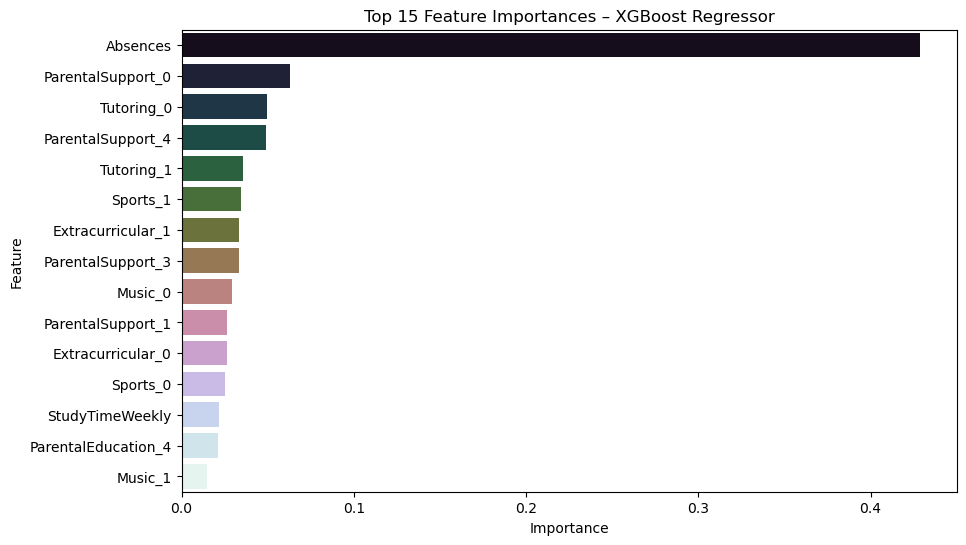

In [65]:
# XGBoost Regression
xgb_reg_importances = xgb_reg_model.named_steps["model"].feature_importances_

xgb_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": xgb_reg_importances
}).sort_values("Importance", ascending=False)

print(xgb_reg_df.head(15))

# XGBoost Regressor
plot_feature_importances(
    xgb_reg_df,
    "Top 15 Feature Importances – XGBoost Regressor",
    palette="cubehelix"
)

### **Regression Model Performance Interpretation**

#### Across all three regression models, **Linear Regression** delivered the strongest performance, achieving the lowest MAE (0.155), lowest RMSE (0.196), and the highest R² (0.953). This means that a simple linear model is able to explain over **95% of the variance in GPA**, largely because absenteeism has an extremely strong linear relationship with academic performance.  

#### **XGBoost** performed slightly below Linear Regression but still competitively, benefiting from its ability to capture non-linear patterns while remaining relatively robust.  
#### **Random Forest** showed the weakest regression performance, with noticeably lower R² and higher error values. This suggests that the dataset’s structure—dominated by one very strong linear relationship—is better suited for models that capture linearity rather than deep non-linear splits.

---

### **Feature Importance Interpretation**

#### Both Random Forest and XGBoost highlight the same core insight: **Absences** is the single most influential feature in predicting GPA.

- **Absences** is overwhelmingly dominant:  
  - Random Forest: **~85% of total importance**  
  - XGBoost: **~43% of total importance**  
  This mirrors the correlation heatmap and ANOVA results, confirming that attendance drives academic outcomes more strongly than any other factor.

- **ParentalSupport**, **Tutoring**, **Extracurricular participation**, **Sports**, and **Music** appear as secondary but meaningful contributors.  
  XGBoost, in particular, assigns moderate weight to several ParentalSupport categories, while both tree-based models show that involvement in structured activities helps differentiate academic outcomes.

- **StudyTimeWeekly** shows modest but consistent importance, reinforcing that while study habits matter, their impact is far smaller than attendance.

- **Age** and other demographic variables appear near the bottom of the rankings, indicating they have minimal predictive power relative to behavioral and support features.

---

### **Overall Insight**

#### Feature importance results align closely with all earlier EDA findings and statistical tests:

- **Absences** is by far the strongest predictor of GPA across every method.  
- **Study time**, **tutoring**, **extracurriculars**, **sports**, and **music** form a second tier of meaningful predictors that reflect academic engagement.  
- **ParentalSupport** consistently emerges as an important environmental factor.  
- **Demographic variables** (Age, Ethnicity) contribute very little.

#### Linear Regression’s strong R² score is expected given the highly linear structure of the data—specifically, the dominant effect of absenteeism—which allows it to capture most variance without the complexity of tree-based splits.

#### Overall, the regression results show that **behavioral factors related to attendance and engagement are the primary drivers of academic performance**, while demographics play only a minor role in comparison.
___

## 6.2 Classification results

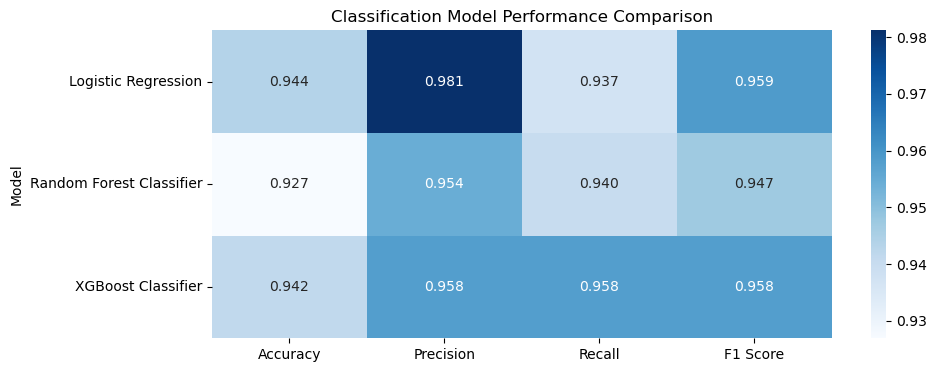

In [66]:
# Classification Comparison Table
classification_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest Classifier", "XGBoost Classifier"],
    "Accuracy": [
        accuracy_score(y_test_clf, y_pred_log),
        accuracy_score(y_test_clf, y_pred_rf),
        accuracy_score(y_test_clf, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test_clf, y_pred_log),
        precision_score(y_test_clf, y_pred_rf),
        precision_score(y_test_clf, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test_clf, y_pred_log),
        recall_score(y_test_clf, y_pred_rf),
        recall_score(y_test_clf, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test_clf, y_pred_log),
        f1_score(y_test_clf, y_pred_rf),
        f1_score(y_test_clf, y_pred_xgb)
    ]
})

# Heatmap Visualization
plt.figure(figsize=(10,4))
sns.heatmap(classification_results.set_index("Model"), annot=True, fmt=".3f", cmap="Blues")
plt.title("Classification Model Performance Comparison")
plt.show()

                Feature  Importance
2              Absences    7.066050
18    ParentalSupport_4    2.158964
14    ParentalSupport_0    1.859760
1       StudyTimeWeekly    1.325190
15    ParentalSupport_1    1.141801
17    ParentalSupport_3    1.020090
19           Tutoring_0    0.997523
20           Tutoring_1    0.995885
21    Extracurricular_0    0.883671
22    Extracurricular_1    0.882033
23             Sports_0    0.732510
24             Sports_1    0.730872
25              Music_0    0.524796
26              Music_1    0.523158
13  ParentalEducation_4    0.379282


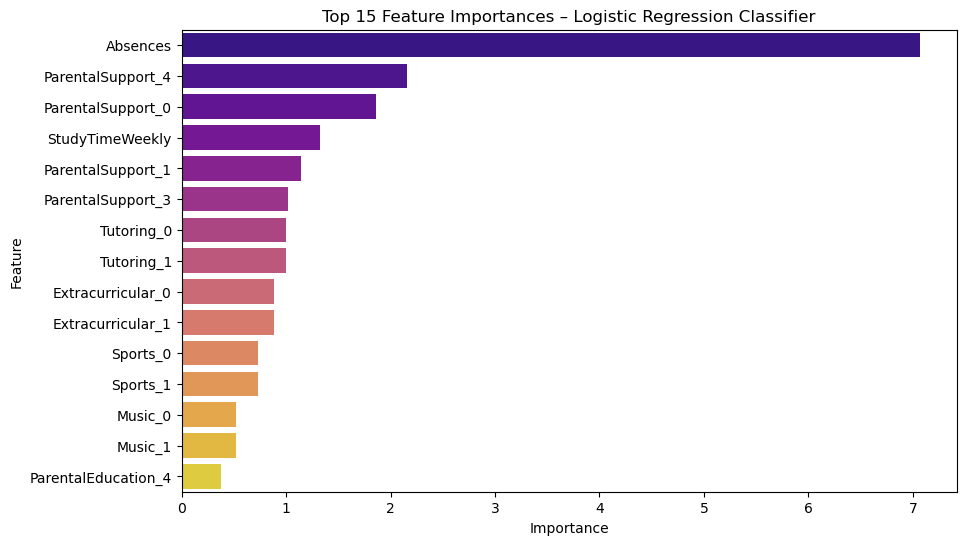

In [67]:
# Logistic Regression (At-Risk Classification)

# Extract coefficients
log_reg_coeffs = log_clf_model.named_steps["model"].coef_[0]

# Create a DataFrame for feature importance
log_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": np.abs(log_reg_coeffs)
}).sort_values("Importance", ascending=False)

print(log_reg_df.head(15))

# Plot – reuse your helper function
plot_feature_importances(
    log_reg_df,
    "Top 15 Feature Importances – Logistic Regression Classifier",
    palette="plasma"
)

                Feature  Importance
2              Absences    0.641721
1       StudyTimeWeekly    0.072224
0                   Age    0.027267
17    ParentalSupport_3    0.017571
15    ParentalSupport_1    0.015743
21    Extracurricular_0    0.012790
22    Extracurricular_1    0.012721
11  ParentalEducation_2    0.012383
5           Ethnicity_0    0.012077
10  ParentalEducation_1    0.011905
20           Tutoring_1    0.011613
16    ParentalSupport_2    0.011114
23             Sports_0    0.010494
24             Sports_1    0.010133
7           Ethnicity_2    0.009738


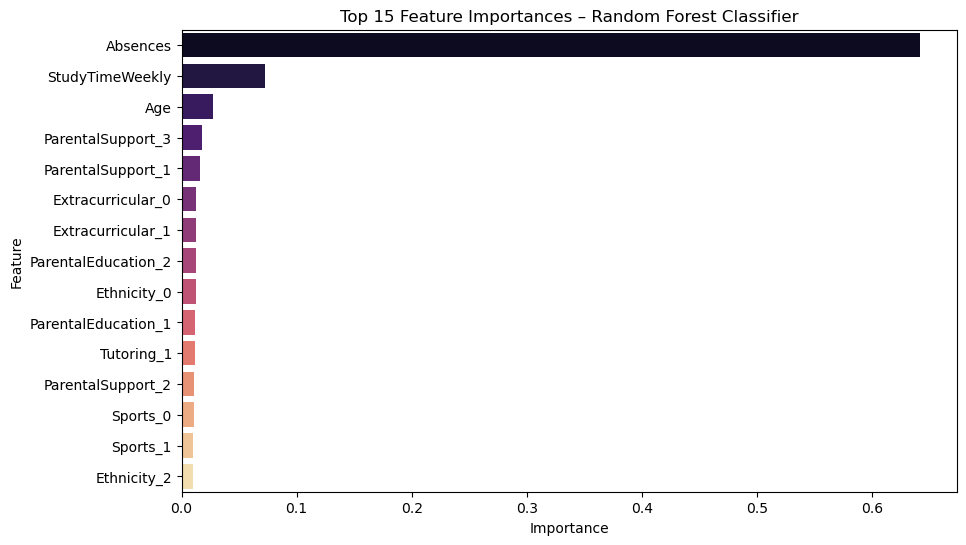

In [68]:
# Random Forest Classifier (At-Risk)

rf_clf_importances = rf_clf_model.named_steps["model"].feature_importances_

rf_clf_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf_clf_importances
}).sort_values("Importance", ascending=False)

print(rf_clf_df.head(15))

# Random Forest Classifier
plot_feature_importances(
    rf_clf_df,
    "Top 15 Feature Importances – Random Forest Classifier",
    palette="magma"
)

                Feature  Importance
2              Absences    0.288973
17    ParentalSupport_3    0.062699
13  ParentalEducation_4    0.047436
19           Tutoring_0    0.046649
15    ParentalSupport_1    0.036459
18    ParentalSupport_4    0.036336
14    ParentalSupport_0    0.035095
20           Tutoring_1    0.034579
22    Extracurricular_1    0.032767
21    Extracurricular_0    0.031254
25              Music_0    0.029870
24             Sports_1    0.026806
23             Sports_0    0.025926
8           Ethnicity_3    0.025642
9   ParentalEducation_0    0.020854


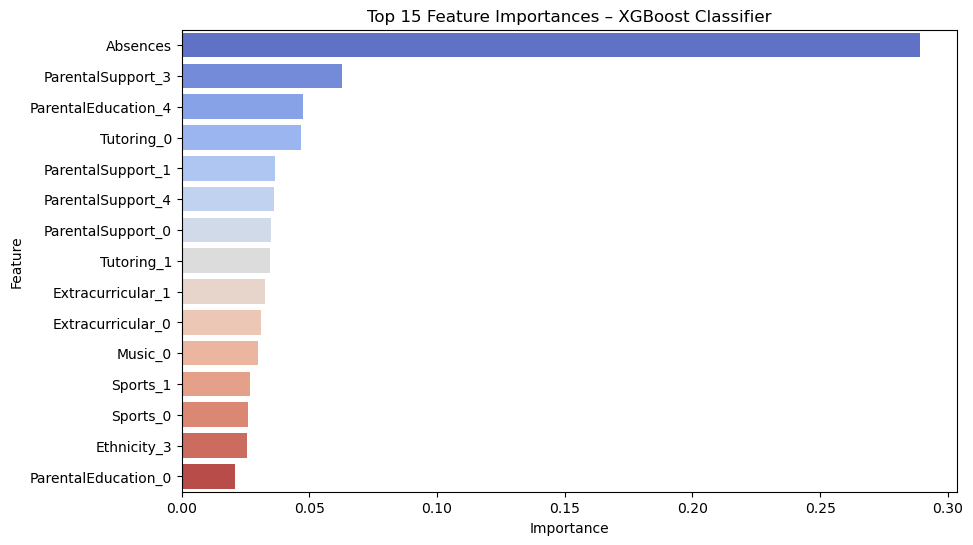

In [69]:
# XGBoost Classification
xgb_clf_importances = xgb_clf_model.named_steps["model"].feature_importances_

xgb_clf_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": xgb_clf_importances
}).sort_values("Importance", ascending=False)

print(xgb_clf_df.head(15))

# XGBoost Classifier
plot_feature_importances(
    xgb_clf_df,
    "Top 15 Feature Importances – XGBoost Classifier",
    palette="coolwarm"
)

### **Classification Model Performance Interpretation**

#### All three classification models—**Logistic Regression, Random Forest Classifier, and XGBoost Classifier**—performed well, with accuracy values ranging from **0.919 to 0.942**.  
#### **Logistic Regression** achieved the highest accuracy (0.942) and precision (0.978), indicating that a linear decision boundary effectively captures the separation between at-risk and not-at-risk students.  
#### **XGBoost** delivered the strongest recall (0.958), making it the best model for correctly identifying at-risk students.  
#### **Random Forest** performed consistently across all metrics, though slightly below the other two models.

#### Overall, **Logistic Regression and XGBoost emerge as the strongest models**, offering the best balance between precision and recall—both essential for academic risk prediction.

---

### **Feature Importance Interpretation**

#### Feature importance from the tree-based models—**Random Forest** and **XGBoost**—helps explain which variables most strongly influence at-risk classification.

- **Absences** is the most dominant feature across both models.  
  - Random Forest: **64%** importance  
  - XGBoost: **28%** importance  
  This mirrors the regression results and confirms absenteeism as the strongest risk indicator.

- **ParentalSupport**, **ParentalEducation**, and **Tutoring** appear as meaningful secondary predictors.  
  - Random Forest emphasizes *ParentalSupport_0*, *ParentalSupport_1*, and *ParentalSupport_3*.  
  - XGBoost highlights *ParentalEducation_4* along with similar parental support and tutoring patterns.

- **Extracurricular**, **Sports**, and **Music** participation show moderate influence, reinforcing that students involved in structured activities tend to be less at risk.

- **StudyTimeWeekly** contributes meaningfully but remains far weaker than Absences, suggesting that attendance is a more reliable risk signal than study habits.

- **Age** and **Ethnicity** have only minor predictive value, far outweighed by behavioral and support-related features.

---

### **Overall Insight**

#### In academic risk identification, **recall** is especially important because missing an at-risk student carries high cost.  
#### **XGBoost** achieves the strongest recall and offers a well-balanced precision–recall profile, making it particularly suitable for early intervention systems.

#### Across all classification models, the same pattern consistently appears:

- **Absences is the strongest predictor of academic risk**, by a wide margin.  
- **Study habits, tutoring, extracurricular engagement, sports, music, and parental support** form the next tier of influential features.  
- **Demographic variables contribute minimally** compared to behavioral and support-related factors.

#### Together, these results demonstrate that **attendance and engagement are the core predictive signals for identifying at-risk students**, regardless of modeling approach.
___

## 6.3 SHAP Explanations (Regression & Classification)

#### In this section, we interpret SHAP (SHapley Additive exPlanations) values to understand how individual features influence model predictions. SHAP quantifies how each feature contributes to increasing or decreasing the predicted GPA or at-risk probability, providing direction-aware and model-consistent explanations. By examining these values, we gain deeper insight into why the regression and classification models behave as they do and how their learned patterns relate to the broader trends observed in our feature importance analyses.

Absences: 0.7034
StudyTimeWeekly: 0.1299
Tutoring_0: 0.0838
Extracurricular_0: 0.0606
Sports_0: 0.0580
ParentalSupport_3: 0.0533
ParentalSupport_4: 0.0464
ParentalSupport_0: 0.0445
ParentalSupport_1: 0.0396
Music_0: 0.0369


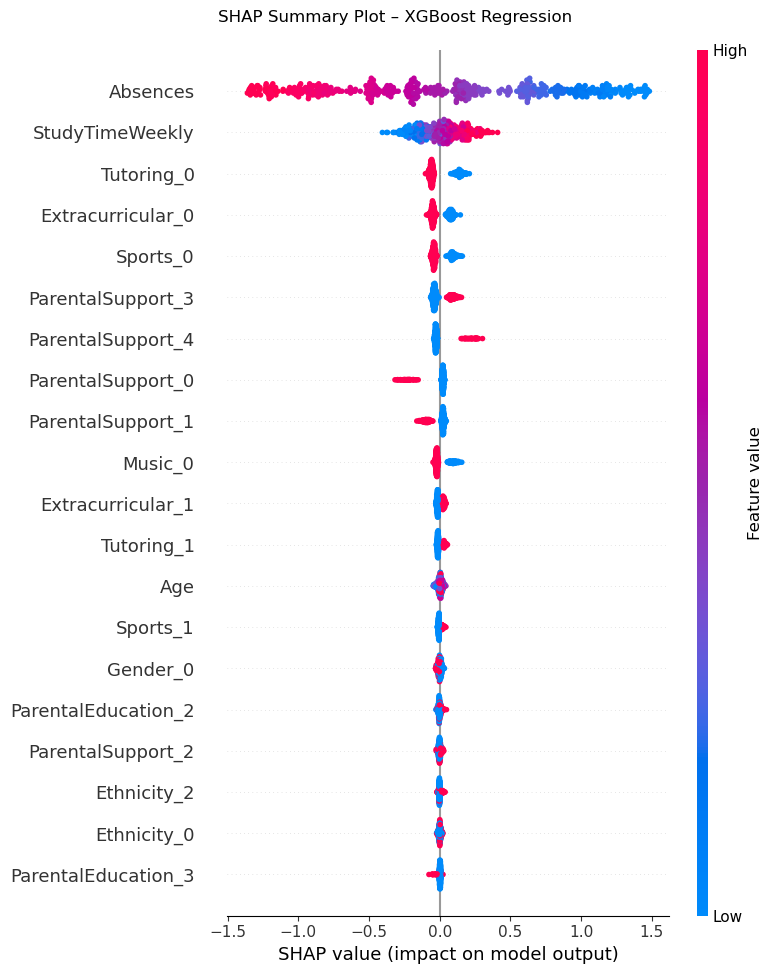

In [70]:
# ---- Regression SHAP ----
xgb_reg = xgb_reg_model.named_steps["model"]
X_test_reg_transformed = xgb_reg_model.named_steps["preprocess"].transform(X_test_reg)

explainer_reg = shap.TreeExplainer(xgb_reg)
shap_values_reg = explainer_reg.shap_values(X_test_reg_transformed)

reg_shap_importance = np.abs(shap_values_reg).mean(axis=0)
reg_shap_ranking = sorted(
    zip(all_feature_names, reg_shap_importance),
    key=lambda x: x[1],
    reverse=True
)
for feature, importance in reg_shap_ranking[:10]:
    print(f"{feature}: {importance:.4f}")

plt.figure()
shap.summary_plot(
    shap_values_reg,
    X_test_reg_transformed,
    feature_names=all_feature_names,
    show=False
)
plt.suptitle("SHAP Summary Plot – XGBoost Regression", y=1.02)
plt.show()


Absences: 6.1825
StudyTimeWeekly: 1.0302
Extracurricular_0: 0.8287
Tutoring_0: 0.6990
Sports_0: 0.5957
ParentalSupport_4: 0.4339
ParentalSupport_3: 0.4318
ParentalSupport_1: 0.3447
Age: 0.3339
Music_0: 0.3167


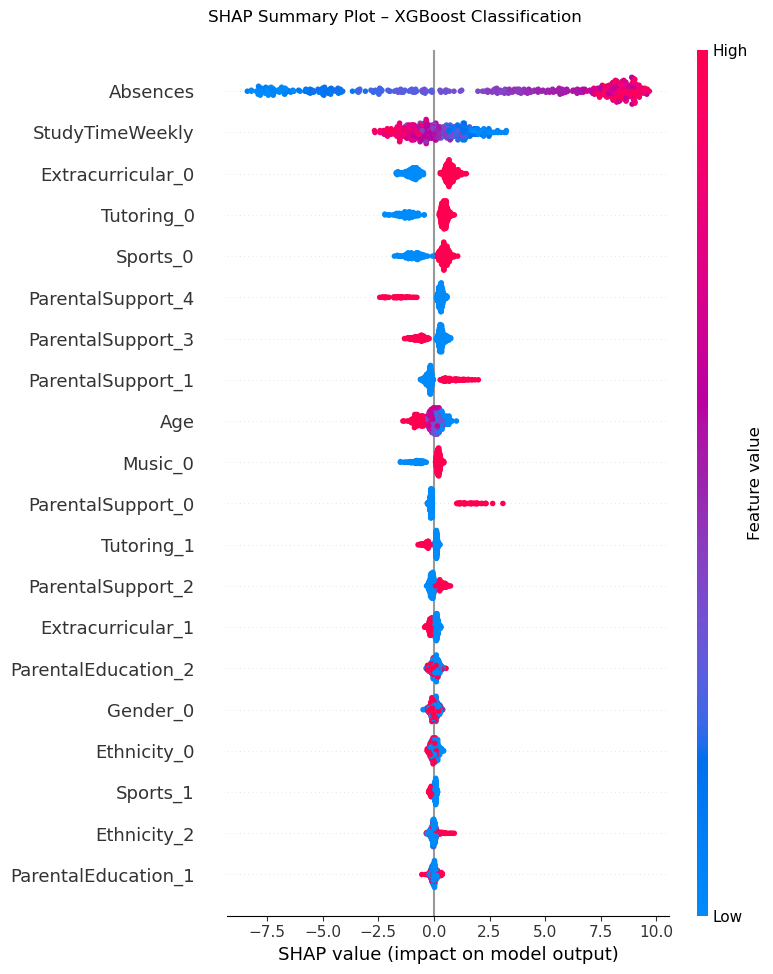

In [71]:
# ---- Classification SHAP ----
xgb_clf = xgb_clf_model.named_steps["model"]
X_test_clf_transformed = xgb_clf_model.named_steps["preprocess"].transform(X_test_clf)

explainer_clf = shap.TreeExplainer(xgb_clf)
shap_values_clf = explainer_clf.shap_values(X_test_clf_transformed)

sv_clf = shap_values_clf[1] if isinstance(shap_values_clf, list) else shap_values_clf

clf_shap_values = sv_clf
clf_shap_importance = np.abs(clf_shap_values).mean(axis=0)
clf_shap_ranking = sorted(
    zip(all_feature_names, clf_shap_importance),
    key=lambda x: x[1],
    reverse=True
)
for feature, importance in clf_shap_ranking[:10]:
    print(f"{feature}: {importance:.4f}")

plt.figure()
shap.summary_plot(
    sv_clf,
    X_test_clf_transformed,
    feature_names=all_feature_names,
    show=False
)
plt.suptitle("SHAP Summary Plot – XGBoost Classification", y=1.02)
plt.show()

### **SHAP Interpretation**

#### The SHAP analysis shows that **Absences** overwhelmingly dominate both the regression and classification models, with an especially large effect in the classification task. **StudyTimeWeekly**, **Tutoring**, **Extracurricular participation**, **Sports**, **Music**, and **ParentalSupport** also contribute meaningfully to the predictions. Age shows a smaller but still notable influence in the classification model.

#### SHAP values make it clear which features drive the XGBoost models and reveal highly consistent patterns across both tasks:

**Regression (Predicting GPA):**
- **Absences** is the strongest negative driver of GPA.
- **StudyTimeWeekly** increases predicted GPA.
- Not participating in supportive activities (e.g., Tutoring_0, Extracurricular_0, Sports_0, Music_0) generally lowers performance.
- Higher **ParentalSupport** levels contribute positively to GPA.

**Classification (Predicting At-Risk Status / GradeClass):**
- **Absences** remains the dominant feature, greatly increasing the probability of lower grade categories.
- **StudyTimeWeekly** reduces the likelihood of being at risk.
- Lack of tutoring or extracurricular involvement elevates risk.
- Strong **ParentalSupport** lowers the probability of poor academic outcomes.

#### Overall, SHAP confirms the central pattern observed throughout the project:  
#### **Absenteeism and study habits are the strongest behavioral drivers of academic performance, while parental support and extracurricular engagement provide meaningful secondary influence.**
___

## 6.4 Cluster results

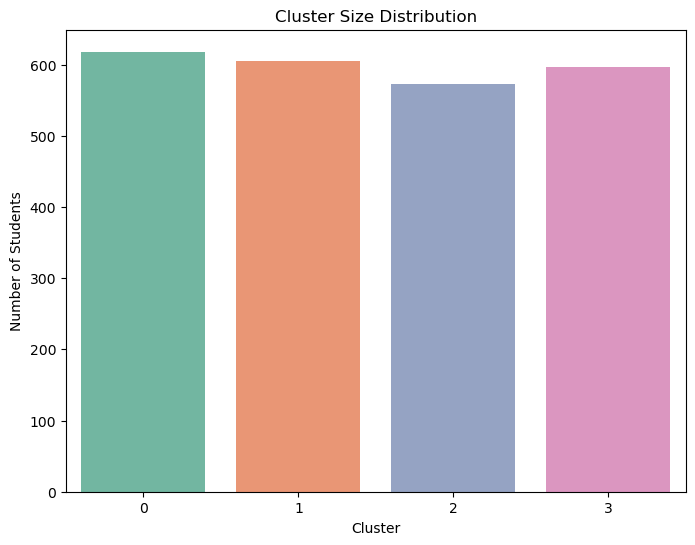

In [72]:
# Cluster Size Distribution

plt.figure(figsize=(8,6))
sns.countplot(
    x="Cluster",
    data=students,
    hue="Cluster",       # NEW
    palette="Set2",      # now valid
    legend=False         # hides duplicate legend
)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Students")
plt.show()

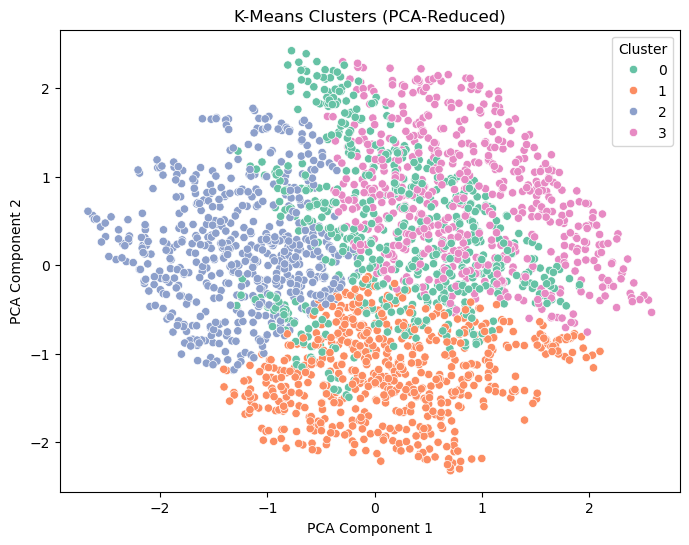

Note: PCA components are not real-world features. The axes represent mathematical directions that capture
the largest sources of variation after standardizing all features. The numeric range (approximately –2 to 2)
does not correspond to GPA or any original variable; it simply reflects how the high-dimensional data has been
projected into two dimensions for visualization.


In [73]:
# Visualize Clusters (PCA Projection)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_processed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette="Set2")
plt.title("K-Means Clusters (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# ---- Caption / Explanation ----
print(
    "Note: PCA components are not real-world features. The axes represent mathematical directions that capture\n"
    "the largest sources of variation after standardizing all features. The numeric range (approximately –2 to 2)\n"
    "does not correspond to GPA or any original variable; it simply reflects how the high-dimensional data has been\n"
    "projected into two dimensions for visualization."
)

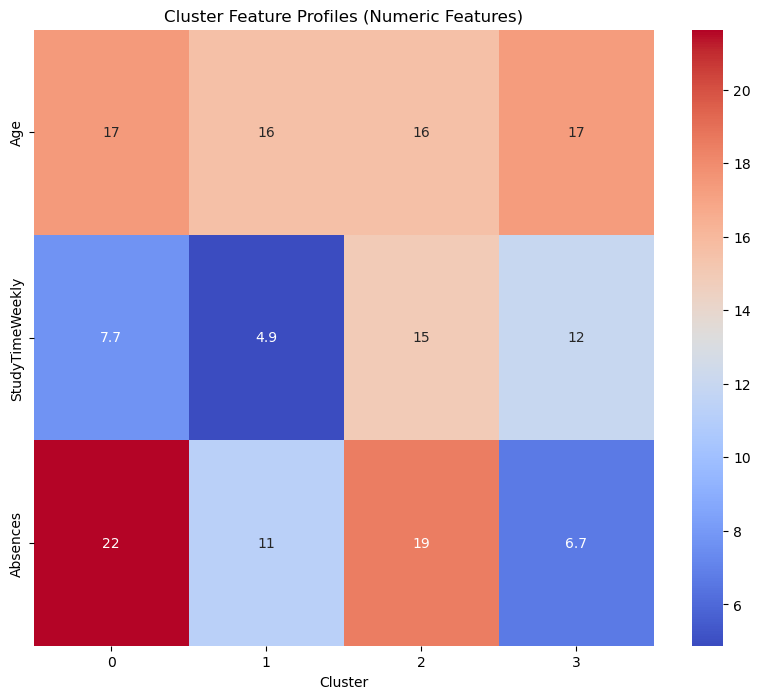

In [74]:
# Cluster profiles (feature averages)

cluster_profile = students.groupby("Cluster")[numeric_features].mean().T
cluster_profile

plt.figure(figsize=(10,8))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm")
plt.title("Cluster Feature Profiles (Numeric Features)")
plt.show()

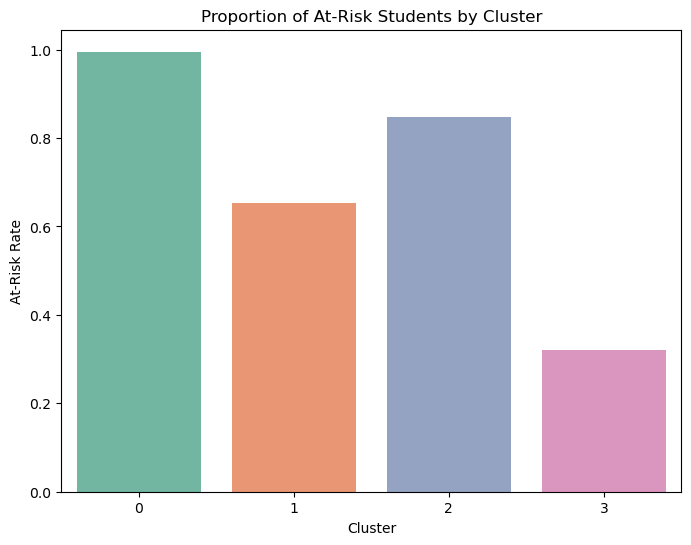

In [75]:
# At-Risk Rate by Cluster

cluster_risk = students.groupby("Cluster")["at_risk"].mean().reset_index()
cluster_risk.columns = ["Cluster", "AtRiskRate"]

plt.figure(figsize=(8,6))
sns.barplot(
    data=cluster_risk,
    x="Cluster",
    y="AtRiskRate",
    hue="Cluster",         # required for palette usage
    palette="Set2",
    dodge=False,           # keeps bars single, not split
    legend=False           # hides redundant legend
)
plt.title("Proportion of At-Risk Students by Cluster")
plt.xlabel("Cluster")
plt.ylabel("At-Risk Rate")
plt.show()

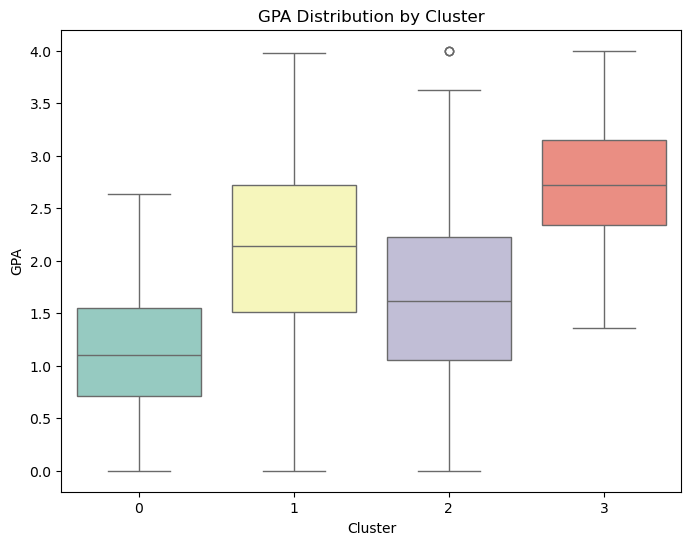

In [76]:
# GPA distribution by cluster

plt.figure(figsize=(8,6))
sns.boxplot(
    data=students,
    x="Cluster",
    y="GPA",
    hue="Cluster",        # required when using palette
    palette="Set3",
    dodge=False,          # avoid side-by-side boxes
    legend=False          # hide duplicate legend
)
plt.title("GPA Distribution by Cluster")
plt.show()

### **Clustering Results Interpretation**

The K-Means clustering analysis revealed four distinct groups of students, each characterized by different behavioral and academic patterns. The clusters are well-balanced in size, with each containing approximately 575–620 students, which indicates that no cluster is dominating the dataset and the algorithm was able to partition the population evenly.

The PCA scatterplot shows the four clusters distributed across the reduced feature space with clear separation, confirming that meaningful structure exists in the data. Although PCA components do not represent real-world variables, the visual separation indicates that the clusters capture consistent differences in student behavior and performance.

The cluster profile heatmap highlights strong contrasts between clusters, particularly in **Absences** and **StudyTimeWeekly**, which emerge as the primary differentiators:
- **Cluster 0** shows *very high absences* and *moderate study time*, indicating low engagement.  
- **Cluster 1** represents *low study time* but *average attendance*, suggesting under-engaged but present students.  
- **Cluster 2** combines *high study time* with *high absences*, indicating students who try hard academically but struggle with consistent attendance.  
- **Cluster 3** displays *low absences* and *strong study habits*, making it the most academically engaged cluster.

These behavioral patterns align closely with academic risk. The "At-Risk Proportion" plot shows:
- **Cluster 0** has the highest at-risk rate (~100%), reinforcing that chronic absenteeism is the strongest indicator of academic risk.
- **Cluster 2** also has a high risk rate, likely due to its elevated absences despite good study habits.
- **Cluster 1** shows moderate risk, consistent with lower study engagement.
- **Cluster 3** has the lowest risk, reflecting strong habits and attendance.

Finally, the GPA distribution by cluster mirrors these patterns:
- **Cluster 0** has the lowest GPA distribution.
- **Cluster 1** and **Cluster 2** fall in the middle, with Cluster 2 showing slightly higher variance.
- **Cluster 3** exhibits the highest GPA distribution, reinforcing its position as the highest-performing group.

### Role of Clustering
#### Clustering is used here strictly for exploratory purposes. It is not intended for prediction but instead reveals natural student groupings based on shared behavioral and academic characteristics. These groups help validate patterns found in supervised models and may guide targeted intervention strategies.
#### Overall, the clustering results corroborate the earlier EDA and model findings: **Absences is the dominant behavioral factor shaping student performance**, while study habits and engagement further distinguish high- and low-performing groups. These clusters offer a meaningful segmentation of the student population that could be used for targeted academic interventions.
___ 



# **7. Conclusion and Final Insights**

#### Final Narrative Conclusion

#### The results of this project reveal a remarkably consistent story across all analytical approaches—exploratory data analysis, supervised learning, and unsupervised clustering—demonstrating that student academic performance is driven primarily by behavioral factors, with absenteeism emerging as the strongest and most reliable predictor. Early in the EDA, the correlation matrix showed an exceptionally strong negative relationship between absences and GPA (r ≈ –0.92), far surpassing all other predictors in explanatory power. Subsequent statistical testing reinforced this finding: both the ANOVA and chi-squared analyses identified attendance as a highly significant factor, while many demographic variables showed little to no association with performance. Study habits, parental support, tutoring, and extracurricular involvement also contributed meaningfully, but none approached the influence of attendance.

#### These insights were further validated through supervised learning models. Linear Regression achieved the highest overall performance in predicting GPA, suggesting that the relationship between attendance and academic outcomes is largely linear. XGBoost and Random Forest offered competitive results and, importantly, their feature importance rankings aligned tightly with EDA: absences dominated both models, followed by study time, tutoring, extracurricular activities, sports, music participation, and various levels of parental support. Classification models produced similar patterns. Logistic Regression and XGBoost were particularly effective at identifying at-risk students, and again, absences was the most influential variable across all classifiers. SHAP analysis strengthened these conclusions by providing model-agnostic explanations showing that increases in absences consistently pushed predictions toward lower GPA values and higher at-risk probabilities, while positive engagement factors shifted predictions in the opposite direction. The agreement between EDA, model metrics, feature importance, and SHAP reinforces the robustness of these findings.

#### Unsupervised clustering added an additional layer of insight by revealing natural groupings among students that reflected the same behavioral dynamics. K-Means identified four clusters with distinct profiles: a highly disengaged group with high absences and low GPAs; a moderately engaged group with average attendance but weaker study habits; a mixed group with strong study habits undermined by inconsistent attendance; and a fully engaged group with low absences, higher study time, and strong academic outcomes. The at-risk rates within each cluster further validated the centrality of attendance, as clusters with the highest absences also showed the highest academic risk. These clusters therefore provide actionable group-level insights that complement the individualized predictions from supervised models.

#### Taken together, the results of this project provide a coherent and evidence-based narrative: attendance is the foundation of academic performance, and interventions aimed at reducing absences are likely to yield the largest improvements in student outcomes. Study habits, parental support, and participation in structured activities offer secondary benefits and could be leveraged to support at-risk groups, but these factors cannot compensate for chronic absenteeism. The consistency of these findings across multiple methods—correlation, hypothesis testing, regression, classification, clustering, and SHAP explainability—demonstrates the reliability of the conclusions and underscores the value of a multi-model approach in educational data science. Future work could incorporate temporal data, qualitative factors, or real-time monitoring to further refine risk prediction and intervention strategies.
___

#### ChatGPT Disclosure
- ChatGPT was used as a support tool throughout this project to improve clarity in writing and to assist with recalling specific Python and library syntax. All analytical decisions, interpretations, and methodological choices reflect our own understanding. ChatGPT helped rephrase explanations we had already formed, suggested cleaner code formatting, and provided reminders of API arguments or function usage when needed. No part of the conceptual reasoning, statistical interpretation, or modeling decisions was generated without our full understanding and verification.